## Photometry data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
metadf = pd.read_parquet(pathfile + 'sessions.pqt')
metadf.reset_index(inplace=True)
metadf.head()

,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
0,34,fe2a712b-014b-47e7-b2ac-f85d0571cf44,ZFM-03065,2021-08-27T10:18:12.784055,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
1,35,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,ZFM-03059,2021-08-27T11:18:32.529960,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
2,38,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,ZFM-03065,2021-08-30T08:29:50.008373,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,5,5HT,[DR],[Region1G]
3,42,c5cdd496-7400-4c0f-b326-55016bce4fcf,ZFM-03065,2021-08-31T10:23:23.726423,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,6,5HT,[DR],[Region1G]
4,49,fd22820d-a2c2-4c06-b90e-f399344e1c0a,ZFM-03059,2021-09-01T09:54:32.034120,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,7,5HT,[DR],[Region1G]


In [2]:
# filter out late-stage training data
metadf[(metadf['session_n'].between(15, 30)) & (metadf['session_type']=='training')] 
meta_train_df = metadf[metadf['session_type']=='training']
meta_train_df.groupby('subject').max('session_n') # mice who completed training faster: ZFM-03059, ZFM-03065

,index,session_n
subject,,
ZFM-03059,144,31
ZFM-03065,153,34
ZFM-05235,1569,67
ZFM-05236,1444,48
ZFM-05245,1473,51
ZFM-05248,1481,54


### Photometry class for functions of loading and plotting

In [3]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

@dataclass
class Params: 
    """
    Parameters for PSTH and photometry analysis.

    Attributes
    ----------
    pre_time : float
        Time before event to include in the analysis window (in seconds).
    post_time : float
        Time after event to include in the analysis window (in seconds).
    bin_size : float
        Size of time bins for the histogram (in seconds).
    baseline_time : float
        Time window before the event used for baseline fluorescence calculation (in seconds).
    """
    pre_time: float=4
    post_time: float=6
    bin_size: float=0.1
    baseline_time: float=0.5

class Photometry: 
    """
    Class for analyzing photometry data aligned to behavioral events.

    Parameters
    ----------
    eid : str
        Experiment ID used to load data files.

    trial_idx : list, optional
        Indices of trial numbers to select from the session. 

    """

    def __init__(self, eid, trial_idx=None):
        
        # private instances
        self.__pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
        self.__eid = eid
        
        if trial_idx is not None:
            self.__trials_df = self.load_trials()[self.convert_trial_idx(trial_idx)]
           
        else: 
            self.__trials_df = self.load_trials()
        
        self.__gcamp_df = self.load_photometry()

        # public instances
        self.firstMovement_times = self.__trials_df['firstMovement_times']
        self.contrastRight = self.__trials_df['contrastRight']
        self.choice = self.__trials_df['choice']
        self.contrastLeft = self.__trials_df['contrastLeft']
        self.response_times = self.__trials_df['response_times']
        self.feedbackType = self.__trials_df['feedbackType']
        self.probabilityLeft = self.__trials_df['probabilityLeft']
        self.stimOn_times = self.__trials_df['stimOn_times']
        self.goCue_times = self.__trials_df['goCue_times']
        self.feedback_times = self.__trials_df['feedback_times']

    
    def convert_trial_idx(self, trial_idx): 
        total_trial = self.load_trials().shape[0]
        if len(trial_idx) == 2:
            tid = [True if i in range(trial_idx[0], trial_idx[1]) else False for i in range(total_trial)]
        else:
            tid = trial_idx
        return tid

    # functions for loading
    def load_photometry(self):
        df = pd.read_parquet(self.__pathfile + self.__eid + '_gcamp.pqt')
        return df

    def load_trials(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_trials.pqt')
        return df

    def load_isosbestic(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_isosbestic.pqt')
        return df

    # Modified based on bin_spikes from brainbox.singlecell 
    def __bin_photometry(self, align_times, params: Params):
        """
        Internal method to compute trial-aligned, binned photometry signal (ΔF/F).
        Each trial is aligned to the specified event, and its fluorescence trace is:
        1. Binned over time relative to the event.
        2. Normalized by its own baseline fluorescence to compute ΔF/F.
        3. Returned as a matrix of shape (n_trials, n_bins).
        """

        # align_times = np.array(self.__trials_df[align_times])
        stimOn_times = np.array(self.__trials_df['stimOn_times'])
       
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            # also account for underlying (longer-term) fluctuations 1 seconds prior to events
            # fluctuation_time = stimOn_times[i] - 1  # 1s window hard-coded!
            # fluctuation_idx = np.searchsorted(times, [fluctuation_time, stimOn_times[i]])
            # fluctuation_signal = signal[fluctuation_idx[0]:fluctuation_idx[1]]
            # if len(fluctuation_signal) > 0:
            #     fluc_std = np.nanstd(fluctuation_signal, axis=0)
            # else:
            #     fluc_std = np.nan

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial
            
            fluc_std = 1 # placeholder

            if not np.isnan(F_baseline) and F_baseline != 0 and not np.isnan(fluc_std) and fluc_std != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline / fluc_std 
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero

        tscale = (tscale[:-1] + tscale[1:]) / 2

        return bins, tscale
    
    def __get_filtered_trials_df(self, side=None, feedback_type=None, bias=None):
        
        # Start with full mask (all True)
        mask = np.ones(len(self.__trials_df), dtype=bool)

        # Apply side filter
        if side == 'left':
            mask &= ~np.isnan(self.__trials_df['contrastLeft'])
        elif side == 'right':
            mask &= ~np.isnan(self.__trials_df['contrastRight'])

        # Apply feedback_type filter
        if feedback_type == 1.0:
            mask &= self.__trials_df['feedbackType'] == 1.0
        elif feedback_type == -1.0:
            mask &= self.__trials_df['feedbackType'] == -1.0
        elif feedback_type is not None:
            raise Exception("feedback_type must be -1.0 (incorrect) or 1.0 (correct)")

        # Apply bias filter
        if bias == 0:
            mask &= self.__trials_df['probabilityLeft'] == 0.5
        elif bias == 1:
            mask &= (self.__trials_df['probabilityLeft'] == 0.2) | (self.__trials_df['probabilityLeft'] == 0.8)
        elif bias is not None:
            raise Exception("bias must be 0 (no bias) or 1 (biased)")
        
        return mask

    
    def get_psth(self, events, params: Params, side=None, contrast=None, feedback_type=None, bias=None):
        """
        Compute PSTH aligned to a specific event with optional filtering by the side, contrast level, 
        feedback type, and bias in experimental setup. 

        Params
        -------
        events : str
            Column name of the event times to align to.
        params : Params
            Analysis parameters.
        side : str, optional
            'left' or 'right' trials.
        contrast : list, optional
            List of contrast levels to include.
        feedback_type : float, optional
            correct trials (1.0) or incorrect trials (-1.0).
        bias: int, optional
            50-50 trials (0) or 20-80 trials (1). 

        Returns
        -------
        psth_avg : np.ndarray of shape (n_bins,)
            The average binned ΔF/F (%) signal across all selected trials.
            Each trial is first normalized to its own baseline before averaging.
            
        tscale : np.ndarray of shape (n_bins,)
            The time points (in seconds) corresponding to the center of each bin.
            
        psth_contrast : dict of {float: np.ndarray of shape (n_bins,)}
            Dictionary mapping each contrast level to the average binned dF/F (%) signal 
            across all trials for that specific contrast level.
        """

        events = np.array(self.__trials_df[events])  # e.g. 'firstMovement_times'
        dF_F, tscale = self.__bin_photometry(events, params)  
       
        # print(f'dF_F shape: {dF_F.shape}')
        # print(f'tscale shape: {tscale.shape}')
        # print(f'trials_df shape {self.__trials_df.shape}')
        # print(f'gcamp_df shape {self.__gcamp_df.shape}')

        if side is not None: 
            left_idx = ~np.isnan(self.contrastLeft)
            self.__left_psth = np.nanmean(dF_F[left_idx], axis=0)
            self.__left_psth_sem = stats.sem(dF_F[left_idx], axis=0, nan_policy='omit')
            right_idx = ~np.isnan(self.contrastRight)
            self.__right_psth = np.nanmean(dF_F[right_idx], axis=0)
            self.__right_psth_sem = stats.sem(dF_F[right_idx], axis=0, nan_policy='omit')
        
        # if feedback_type is not None: 
        correct_idx = self.feedbackType == 1.0
        self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
        self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
        incorrect_idx = self.feedbackType == -1.0
        self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
        self.__incorrect_psth_sem = stats.sem(dF_F[incorrect_idx], axis=0, nan_policy='omit')

        if bias is not None: 
            no_bias_idx = self.probabilityLeft == 0.5
            self.__no_bias_psth = np.nanmean(dF_F[no_bias_idx], axis=0)
            self.__no_bias_psth_sem = stats.sem(dF_F[no_bias_idx], axis=0, nan_policy='omit')

            # skip if no bias trials
            if (0.8 in self.probabilityLeft.unique()) | (0.2 in self.probabilityLeft.unique()):
                bias_idx = (self.probabilityLeft == 0.2) | (self.probabilityLeft == 0.8)
                self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
                self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')

        # filter data
        mask = self.__get_filtered_trials_df(side=side, feedback_type=feedback_type, bias=bias)
        trials = dF_F[mask]
        trials_data = self.__trials_df[mask]

        # take the average over all identified trials
        psth_avg = np.nanmean(trials, axis=0) 
        # self._psth_sem = np.nanstd(trials, axis=0) / np.sqrt(trials.shape[0]) 
        self._psth_sem = stats.sem(trials, axis=0, nan_policy='omit')
        
        # store psth for different contrast levels
        psth_contrast = {}
        self._psth_contrast_sem = {}
        
        if contrast is not None:

            contrast.sort()

            for level in contrast:
                # trial indices for this difficulty
                idx = np.where((trials_data['contrastLeft'] == level)|(trials_data['contrastRight'] == level))[0] 
                if len(idx) == 0:
                    continue  # skip if no trials of this level
        
                psth_contrast[level] = np.nanmean(trials[idx], axis=0) # store for this level
                # self._psth_contrast_sem[level] = np.nanstd(trials[idx], axis=0) / np.sqrt(trials[idx].shape[0])
                self._psth_contrast_sem[level] = stats.sem(trials[idx], axis=0, nan_policy='omit')
            
            return psth_avg, tscale, psth_contrast
        
        else:
            return psth_avg, tscale
        
    def trial_psth(self, events, trial_idx, window=1):
        
        trial_data = self.__trials_df.iloc[trial_idx : trial_idx + 2]
        event_time = trial_data.iloc[0][events]
        trial_start = trial_data.iloc[0]['goCue_times']
        trial_end = trial_data.iloc[1]['goCue_times']

        # Get the gcamp timestamps
        gcamp_df = self.__gcamp_df
        timestamps = gcamp_df.index.values

        # Find the closest indices to trial_start and trial_end
        start_idx = np.searchsorted(timestamps, trial_start, side='left')
        end_idx = np.searchsorted(timestamps, trial_end, side='right')

        # Slice using .iloc for position-based indexing
        gcamp_data = gcamp_df.iloc[start_idx : end_idx]

        trial_timestamps = gcamp_data.index.values
        evt_start = np.searchsorted(trial_timestamps, event_time, side='left')
        evt_end = np.searchsorted(trial_timestamps, event_time + window, side='right')
        response_series = gcamp_data.iloc[evt_start : evt_end].iloc[:, 0]  # first column
       
        # realign indices to event time
        relative_times = trial_timestamps[evt_start : evt_end] - event_time
        response_series.index = relative_times
        response_avg = response_series.mean()

        return response_series, response_avg

    # this is not exactly working, the alignment is weird
    def stack_trial_traces(self, events, trial_indices, window=1.0):
        """
        Extract and align traces for multiple trials into a matrix.

        Returns:
            aligned_matrix (pd.DataFrame): rows are trials, columns are aligned time points.
        """
        all_traces = []
        trial_indices = range(trial_indices[0], trial_indices[1]+1)

        for idx in trial_indices:
            try:
                trace, _ = self.trial_psth(events, idx, window)
                all_traces.append(trace)
            except Exception as e:
                print(f"Skipping trial {idx} due to error: {e}")
                continue

        # Combine into a DataFrame (outer join to align on time)
        aligned_df = pd.DataFrame(all_traces)

        # Sort columns by time (aligned index)
        aligned_df = aligned_df.reindex(sorted(aligned_df.columns), axis=1)

        return aligned_df

    
    def fluctuations(self, align_times, params: Params):
        
        align_times = np.array(self.__trials_df[align_times])
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))
        fluc_stds = np.zeros(shape=(align_times.shape[0], n_bins))
        baselines = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            # also account for underlying (longer-term) fluctuations one second prior to events
            fluctuation_time = align_times[i] - 3  # 1s window hard-coded!
            fluctuation_idx = np.searchsorted(times, [fluctuation_time, align_times[i]])
            fluctuation_signal = signal[fluctuation_idx[0]:fluctuation_idx[1]]
            if len(fluctuation_signal) > 0:
                fluc_std = np.nanstd(fluctuation_signal, axis=0)
            else:
                fluc_std = np.nan

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial

            if not np.isnan(F_baseline) and F_baseline != 0 and not np.isnan(fluc_std) and fluc_std != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline / fluc_std 
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero
            
            fluc_stds[i, :] = fluc_std
            baselines[i, :] = F_baseline

        tscale = (tscale[:-1] + tscale[1:]) / 2

          
        return binned_signal, bins, baselines, fluc_stds

    def sessions_avg_psth(eids, events, params):
        
        bin_store = []
        for eid in eids: 
            try:
                bin = Photometry(eid=eid).get_psth(events, params)[0]
                bin_store.append(bin)
            except:
                continue
        
        return np.mean(bin_store, axis=0)
    
    def plot_psth(self, events, params: Params):
        """
        Plot PSTH for all trials.
        """

        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        psth, tscale = self.get_psth(events, params)
        
        plt.figure(figsize=(8, 6))
        sem = self._psth_sem
        plt.plot(tscale, psth, c='g')
        plt.fill_between(tscale, psth - sem, psth + sem, color='g', alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of Serotonin Signal relative to {events}')
        plt.axvline(0, c='k', linestyle='--')
        plt.show()
    
    def sessions_plot(eids, events, params, trial_idx=None):

        bin_store = []
        ts_store = []
        n_lines = len(eids)
        palette = sns.color_palette("YlOrBr", n_lines) 
        idx = 0
        plt.figure(figsize=(8, 6))

        for eid in eids:
            try:
                sesh = Photometry(eid, trial_idx=trial_idx)
                bin, ts = sesh.get_psth(events, params)
                bin_store.append(bin)
                ts_store.append(ts)
                # plt.plot(ts, bin, color=palette[idx], label=f'session {idx + 1}')
                idx += 1
            except Exception as e:
                print(f"Skipping {eid} due to error: {e}")
                continue
        
        if len(ts_store) == 0:
            raise ValueError("No sessions produced valid PSTHs — check get_psth or session data.")
        
        bin_avg = np.nanmean(bin_store, axis=0)
        bin_sem = stats.sem(bin_store, axis=0, nan_policy='omit')

        sem = bin_sem
        tscale = ts_store[0]
        plt.plot(tscale, bin_avg, c='g')
        plt.fill_between(tscale, bin_avg - sem, bin_avg + sem, color='g', alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of fluorescence relative to {events}')
        plt.axvline(0, c='k', linestyle='--')
        plt.show()

        # sns.kdeplot(bin_avg, bw_adjust=0.1)

    def plot_psth_by_contrast_level(self, events, contrast, params: Params):
        """
        Plot PSTH by side or contrast levels.
        """
        
        if not hasattr(self, '_psth_sem'):
            raise ValueError("Call get_psth() before plotting to compute SEM.")

        tscale, psth_contrast = self.get_psth(events, params, contrast=contrast)[1:]
        
        plt.figure(figsize=(8, 6))
        n_lines = len(contrast)
        palette = sns.color_palette("YlOrBr", n_lines) 
        idx = 0

        for level, psth in psth_contrast.items():
            sem = self._psth_contrast_sem[level]
            plt.plot(tscale, psth, color=palette[idx], label=f'Contrast level: {level}')
            plt.fill_between(tscale, psth - sem, psth + sem,
                        color=palette[idx], alpha=0.2)
            idx += 1

        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        # plt.ylim(-1, 1.2)
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by Trial Difficulty')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_feedback_type(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__correct_psth, color=palette[0], label='correct trials')
        plt.plot(tscale, self.__incorrect_psth, color=palette[1], label='incorrect trials')
        plt.fill_between(tscale, self.__correct_psth - self.__correct_psth_sem, self.__correct_psth + self.__correct_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__incorrect_psth - self.__incorrect_psth_sem, self.__incorrect_psth + self.__incorrect_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by feedback type')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_bias(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__no_bias_psth, color=palette[0], label='50-50 trials')
        plt.plot(tscale, self.__bias_psth, color=palette[1], label='80-20 trials')
        plt.fill_between(tscale, self.__no_bias_psth - self.__no_bias_psth_sem, self.__no_bias_psth + self.__no_bias_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__bias_psth - self.__bias_psth_sem, self.__bias_psth + self.__bias_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by bias probability')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_psth_by_side(self, events, params: Params):
        
        tscale = self.get_psth(events, params)[1]

        plt.figure(figsize=(8, 6))
        n_lines = 2
        palette = sns.color_palette("YlOrBr", n_lines) 

        plt.plot(tscale, self.__left_psth, color=palette[0], label='left trials')
        plt.plot(tscale, self.__right_psth, color=palette[1], label='right trials')
        plt.fill_between(tscale, self.__left_psth - self.__left_psth_sem, self.__left_psth + self.__left_psth_sem,
                        color=palette[0], alpha=0.2)
        plt.fill_between(tscale, self.__right_psth - self.__right_psth_sem, self.__right_psth + self.__right_psth_sem,
                        color=palette[1], alpha=0.2)
        plt.xlabel('Time (s)')
        plt.ylabel('ΔF/F')
        plt.title(f'PSTH of Serotonin Signaling Relative to {events} by side')
        plt.axvline(0, c='k', linestyle='--')
        plt.legend()
        plt.show()


## Quality Control

In [6]:
import sys
# Change this to your path to ibl-photometry
sys.path.append('/Users/sarahhu/ibl-photometry/src')

In [7]:
from iblphotometry.metrics import n_early_samples, n_unique_samples, ar_score
from scipy.signal import medfilt

def sliding_deviance(
    A: pd.Series | np.ndarray,
    w_len: int = 151,
) -> float:
    a = A.values if isinstance(A, pd.Series) else A
    running_median = medfilt(a, kernel_size=w_len)
    return np.median(np.abs(a - running_median) / running_median)

In [8]:
eid_qcd = []
unique_sample_threshold = 500 # no difference between 100 and 500 cutoffs, so will keep at 500. 
deviance_threshold = 0.0005 # 0.001 gives 132 sessions (around half of total) whereas 0.0005 gives 160 sessions.  
arscore_threshold = 0.5 # no difference between 0.25 and 0.5 cutoffs, so will keep at 0.5

for eid in metadf['eid']:
    session = Photometry(eid)
    gcamp = session.load_photometry()
    iso = session.load_isosbestic()

    # Check that all samples are appropriately timed
    # Early samples are an indication that there are artifacts/ gcamp-iso identity swaps
    early_gcamp = n_early_samples(gcamp)
    early_iso = n_early_samples(iso)
    print(f'session {eid} early samples gcamp: {early_gcamp}, early samples iso: {early_iso}')

    if early_gcamp == 0 and early_iso == 0:

        # Check that the recording has a high (>100, >1000) number of unique samples
        # A low number indicates that the channel label is wrong, or the signal is too low amplitude
        unique = n_unique_samples(gcamp)
        print(f'session {eid} unique samples: {unique}')

        if unique >= unique_sample_threshold: 

            # Check that the recording has a high amplitude ("median absolute deviance")
            deviance = sliding_deviance(gcamp[gcamp.columns[0]])
            print(deviance, deviance > deviance_threshold)

            # A simple "autoregressive" model tries to predict the signal based on preceding samples
            r_squared = ar_score(gcamp[gcamp.columns[0]])
            print(r_squared, r_squared > arscore_threshold) 

            if deviance > deviance_threshold and r_squared > arscore_threshold:

                eid_qcd.append(eid)


session fe2a712b-014b-47e7-b2ac-f85d0571cf44 early samples gcamp: 0, early samples iso: 0
session fe2a712b-014b-47e7-b2ac-f85d0571cf44 unique samples: 15805
0.022407527481648037 True
0.9506278601087761 True
session ba01bf35-8a0d-4ca3-a66e-b3a540b21128 early samples gcamp: 0, early samples iso: 0
session ba01bf35-8a0d-4ca3-a66e-b3a540b21128 unique samples: 13190
0.0022168539041959702 True
0.9982377390539613 True
session f2a6559d-1e45-4e83-8f65-1295ef50ed4b early samples gcamp: 0, early samples iso: 0
session f2a6559d-1e45-4e83-8f65-1295ef50ed4b unique samples: 15231
0.026056361403386304 True
0.9277222267451728 True
session c5cdd496-7400-4c0f-b326-55016bce4fcf early samples gcamp: 20, early samples iso: 20
session fd22820d-a2c2-4c06-b90e-f399344e1c0a early samples gcamp: 0, early samples iso: 0
session fd22820d-a2c2-4c06-b90e-f399344e1c0a unique samples: 7066
0.0032423367230354156 True
0.989496217315941 True
session 92bf91b5-75db-4e95-8623-fd32c615558f early samples gcamp: 0, early sampl

In [ ]:
metadf_qcd = metadf[metadf['eid'].isin(eid_qcd)]
metadf_qcd

,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
0,34,fe2a712b-014b-47e7-b2ac-f85d0571cf44,ZFM-03065,2021-08-27T10:18:12.784055,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
1,35,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,ZFM-03059,2021-08-27T11:18:32.529960,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
2,38,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,ZFM-03065,2021-08-30T08:29:50.008373,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,5,5HT,[DR],[Region1G]
4,49,fd22820d-a2c2-4c06-b90e-f399344e1c0a,ZFM-03059,2021-09-01T09:54:32.034120,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,7,5HT,[DR],[Region1G]
5,50,92bf91b5-75db-4e95-8623-fd32c615558f,ZFM-03065,2021-09-02T10:28:21.407834,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,8,5HT,[DR],[Region1G]
...,...,...,...,...,...,...,...,...,...,...
257,1809,24415d91-8a3a-440b-beee-2d4388a4b908,ZFM-05248,2023-08-17T07:09:21.348335,_iblrig_tasks_biasedChoiceWorld_ephyssessions,biased,89,5HT,[DR],[Region4G]
258,1818,61073b6e-842e-440e-bf59-b3197065bfa1,ZFM-05248,2023-08-18T08:25:24.087724,_iblrig_tasks_biasedChoiceWorld_ephyssessions,biased,90,5HT,[DR],[Region4G]
260,1836,a196fce9-7eae-4c11-ae01-25a9aa59b593,ZFM-05235,2023-08-23T06:51:52.029815,_iblrig_NPH_tasks_biasedChoiceWorld,biased,97,5HT,[DR],[Region3G]
261,1847,933765b5-1f4e-4877-b889-7cc87f6ddb64,ZFM-05235,2023-08-24T09:31:08.820731,_iblrig_NPH_tasks_biasedChoiceWorld,biased,98,5HT,[DR],[Region3G]


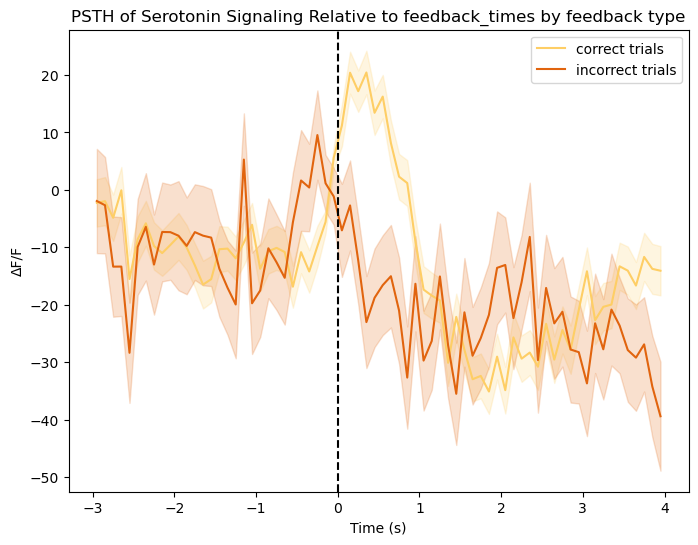

In [88]:
session1 = Photometry('20fb5a24-a1b0-4538-803c-cf13eaff2af6')
session1.plot_psth_by_feedback_type('feedback_times', params=Params(pre_time=3, post_time=4, bin_size=0.1, baseline_time=0.2))

[ 47.0588658   41.21904108  42.28265302  40.75149444  38.72353733
  42.10425068  50.56539781  50.32519351  44.28395657  52.12556043
  46.35839033  39.78993865  45.25847186  44.22220937  36.11659004
  21.22125021   8.46920787  -4.81988302 -12.85859665 -14.23489796
  -9.15698404   5.9290634   57.46337424  64.04559768  40.14028331
  57.96881496 109.44495611 162.34582265 175.71256411 168.03137981
 144.7285809  126.34799718  96.42681919  61.7308262   50.79700344
  43.9972259   34.61724012  22.64204789  21.44941701  26.78597642
  36.11473913  28.19918123  26.94774089  25.86732219  20.56006538
  21.02043304  14.4892645   18.97009122  28.25050518  35.64458244
  43.75801836  50.38783784  60.73219373  59.11310324  57.64471231
  52.7763343   52.54934785  65.51700373  67.66000795  79.28311649]
{0: array([ 28.80056147,  44.68363312,  43.45567354,  29.07789792,
        25.53334421,  30.1716691 ,  47.89098051,  57.72838364,
        32.94492547,  53.04976557,  43.18097214,  20.59133483,
        42.228

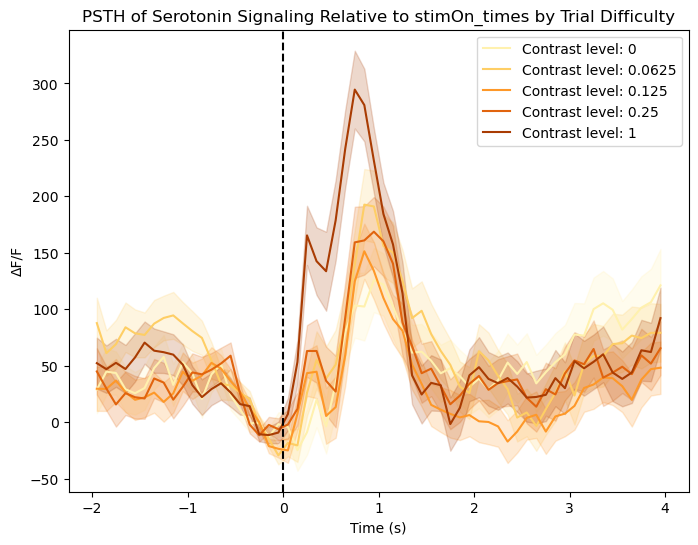

(array([0.00443417, 0.00443004, 0.00443214, 0.00442032, 0.00443229,
        0.00444324, 0.0044449 , 0.00442946, 0.00442707, 0.00442119,
        0.00442525, 0.0044122 , 0.00443765, 0.00444048, 0.00442119,
        0.00442656, 0.00441938, 0.00441162, 0.00440988, 0.00440234,
        0.00441068, 0.00441191, 0.00448254, 0.00451648, 0.00453482,
        0.00452271, 0.0045127 , 0.00451517, 0.00447166, 0.00447514,
        0.00448036, 0.00445005, 0.00446811, 0.00445165, 0.00445411,
        0.00443076, 0.00445063, 0.00443642, 0.00441938, 0.00444251,
        0.00446238, 0.0044602 , 0.00447152, 0.00448674, 0.00449936,
        0.00449414, 0.00448334, 0.00448442, 0.00445984, 0.00446934,
        0.00447014, 0.00447775, 0.00446601, 0.0044486 , 0.00446165,
        0.00450081, 0.00448015, 0.00448442, 0.0044771 , 0.00446064]),
 array([[ 515.31166406,  427.63215616,  680.29440675, ...,  206.6175386 ,
           80.54582013,  -57.1992056 ],
        [-260.10101208, -106.99689807, -220.68110227, ..., -424.1159

In [16]:
# focus on one mouse: ZFM-03059
# extract all/some of its training session eids
# mouse_df = metadf[metadf['subject']=='ZFM-03059']
# train_idx = np.asarray(mouse_df['session_type']=='training').nonzero()
# mouse_train_df = mouse_df.iloc[train_idx]
# sessions = mouse_train_df['eid'][10:15]
# sessions

params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.5)
session1 = Photometry(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3')
psth_avg, tscale, psth_contrast = session1.get_psth('stimOn_times', contrast=[1, 0.0625, 0.25, 0.125, 0], params=params)

print(psth_avg)
print(psth_contrast)
 
# session1.plot_psth('stimOn_times', params=params)
session1.plot_psth_by_contrast_level('stimOn_times', contrast=[1, 0.0625, 0.25, 0.125, 0], params=params)
session1.fluctuations('stimOn_times', params=params)

              Region1G
times                 
-18.239284    0.009775
-18.172629    0.009869
-18.105942    0.009989
-18.039287    0.009890
-17.972632    0.009766
...                ...
 2784.150687  0.008516
 2784.217342  0.008444
 2784.283997  0.008486
 2784.350652  0.008537
 2784.417339  0.008502

[42043 rows x 1 columns]


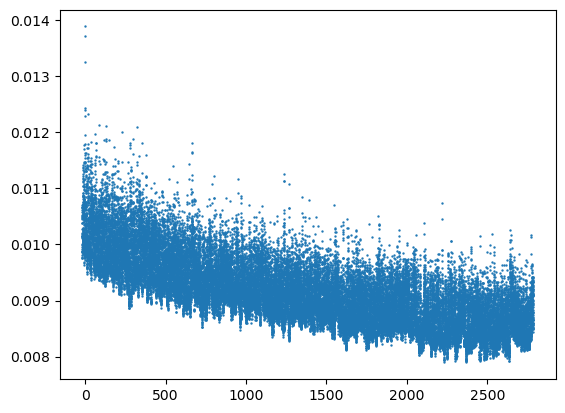

In [ ]:
session1 = Photometry(eid=meta_train_df['eid'][2])
df = session1.load_photometry()
print(df)

plt.scatter(df.index, df, s=0.5)

In [13]:
# a quick check: plot for every trial the total activity during the baseline period, to see if you get a normal distribution. 
def plot_baseline():
       
        signal = session1.load_photometry().values
        times = list(session1.load_photometry().index)
        align_times = np.array(session1.load_trials()['firstMovement_times'])
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        # n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        # bins = np.zeros(shape=(align_times.shape[0], n_bins))
        baseline = np.zeros(shape=(align_times.shape[0], ))

        for i, ep in enumerate(epoch_idxs):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            baseline[i] = F_baseline
        
        
        plt.figure(figsize=(8, 6))
        plt.title('Trial-level activity during baseline period in example session')
        plt.hist(baseline, bins=30)
        plt.show()


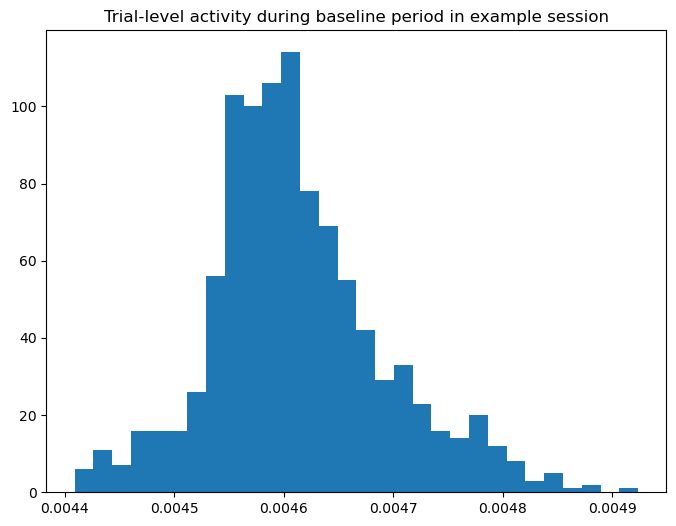

In [17]:
plot_baseline()

In [12]:
performance_df = pd.read_parquet('/Users/sarahhu/Downloads/performance_SERT_eid.parquet')
performance_df

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
0,ZFM-03059,1,habituation,b105bea6-b3d4-46e2-af41-4e7e53277f27,96,96,1.000000
1,ZFM-03059,2,habituation,0fa78e73-a223-4e55-a524-a839262308e6,64,64,1.000000
2,ZFM-03059,3,training,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,178,70,0.393258
3,ZFM-03059,4,training,00575787-7b8a-431a-a70e-1df857871a64,278,93,0.334532
4,ZFM-03059,5,training,12b299c1-69de-4c40-a8a3-c83d13d77a31,225,97,0.431111
...,...,...,...,...,...,...,...
575,ZFM-05248,65,bias,65b43acb-afa5-4590-a400-f7f4c79788ab,182,170,0.934066
576,ZFM-05248,66,bias,9c86d1db-cb3f-4bfe-bdd4-450c25b1b779,262,239,0.912214
577,ZFM-05248,67,bias,b46d38e4-cba5-4d2f-b975-93542a452317,113,101,0.893805
578,ZFM-05248,68,bias,f416af34-121d-419c-8d27-4e95f8648012,168,161,0.958333


Skipping 00575787-7b8a-431a-a70e-1df857871a64 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/00575787-7b8a-431a-a70e-1df857871a64_trials.pqt'
Skipping 12b299c1-69de-4c40-a8a3-c83d13d77a31 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/12b299c1-69de-4c40-a8a3-c83d13d77a31_trials.pqt'


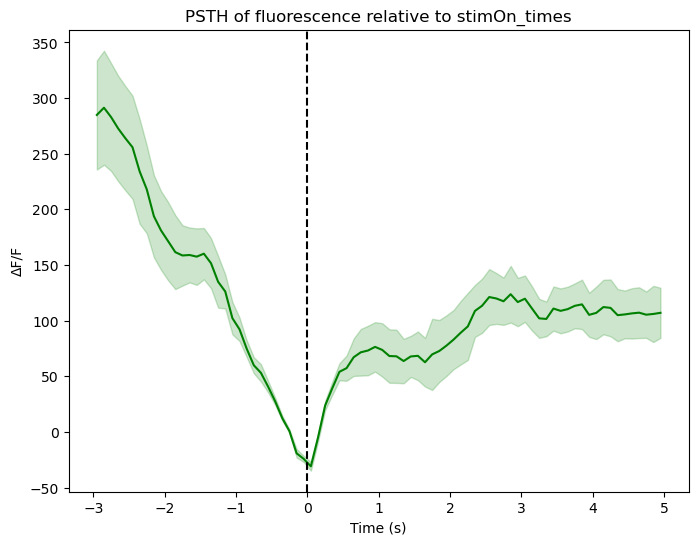

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


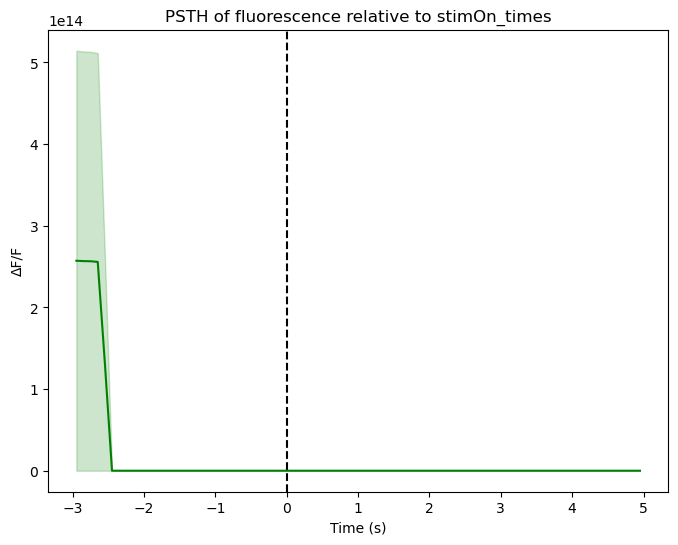

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:252: RuntimeWarning: Mean of empty slice
  self.__bias_psth = np.nanmean(dF_F[bias_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_38954/2660722652.py:253: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__bias_psth_sem = stats.sem(dF_F[bias_idx], axis=0, nan_policy='omit')
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/num

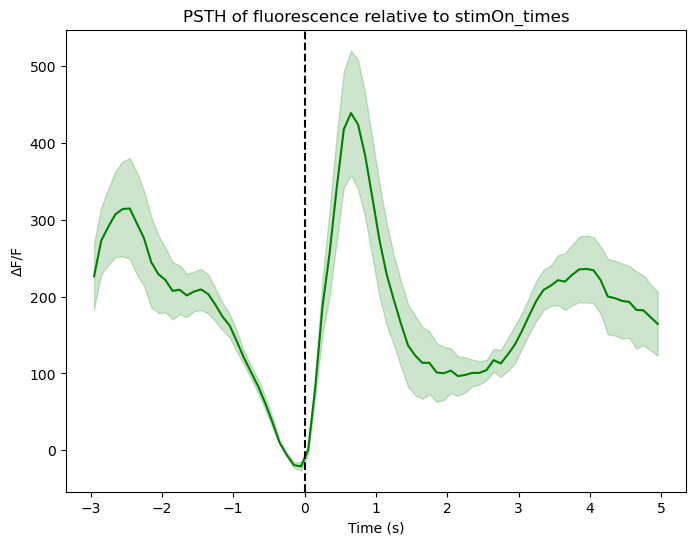

Skipping 00575787-7b8a-431a-a70e-1df857871a64 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/00575787-7b8a-431a-a70e-1df857871a64_trials.pqt'
Skipping 12b299c1-69de-4c40-a8a3-c83d13d77a31 due to error: [Errno 2] No such file or directory: '/Users/sarahhu/ibl_photometry/DR-5HT/12b299c1-69de-4c40-a8a3-c83d13d77a31_trials.pqt'


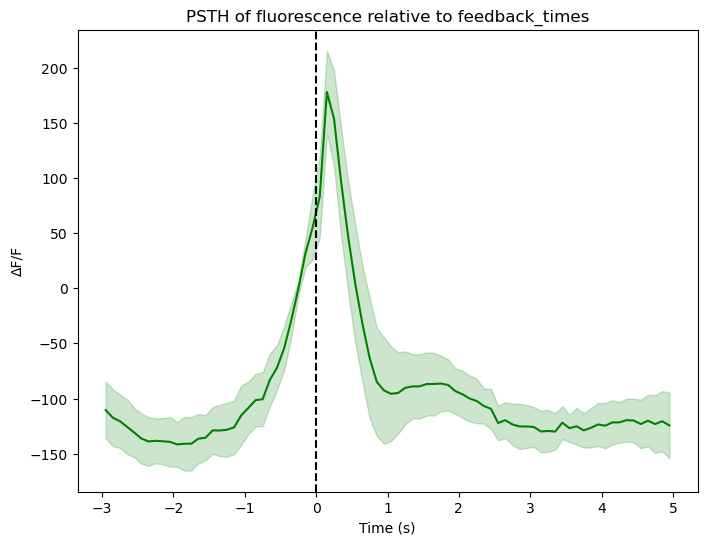

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


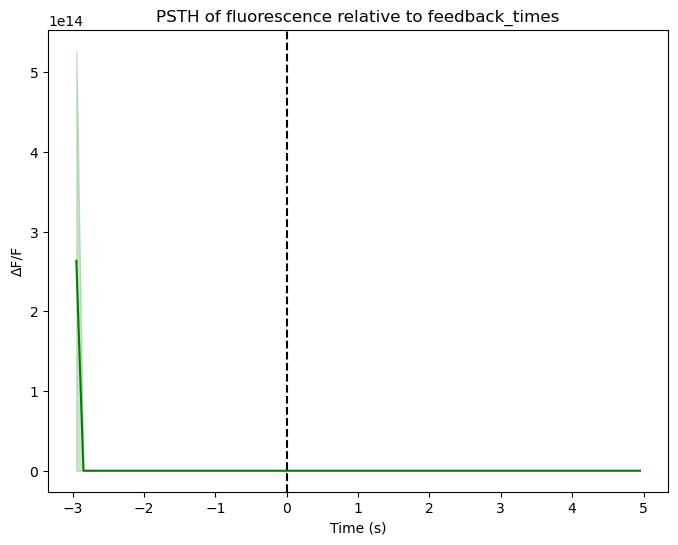

/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


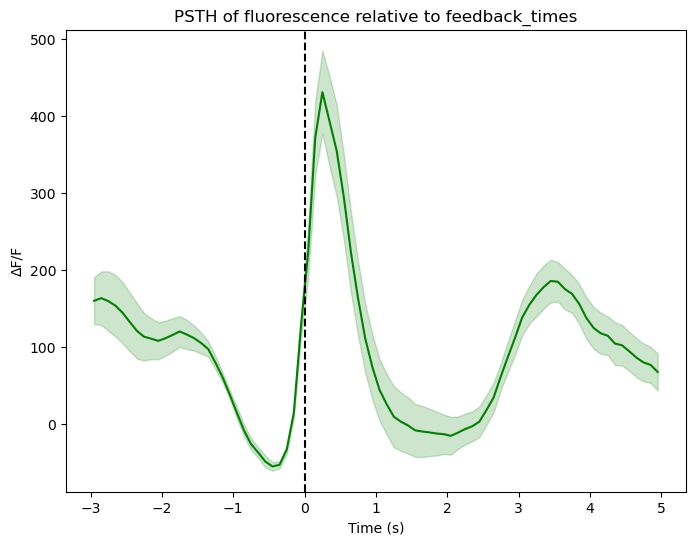

In [ ]:
# Separate into three training phases, see if the responses change to both stimulus onset 
performance_df
eids_early = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(3, 8))]['eid'].values)
eids_middle = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(9, 15))]['eid'].values)
eids_late = list(performance_df[(performance_df['subject']=='ZFM-03059') & (performance_df['stage']=='training')
                            & (performance_df['session_num'].between(16, 25))]['eid'].values)
print(eids_early)
print(eids_middle)
print(eids_late)

Photometry.sessions_plot(eids=eids_early, events='stimOn_times', params=params)
Photometry.sessions_plot(eids=eids_middle, events='stimOn_times', params=params)
Photometry.sessions_plot(eids=eids_late, events='stimOn_times', params=params)

Photometry.sessions_plot(eids=eids_early, events='feedback_times', params=params)
Photometry.sessions_plot(eids=eids_middle, events='feedback_times', params=params)
Photometry.sessions_plot(eids=eids_late, events='feedback_times', params=params)

# Photometry.sessions_plot(eids=eids_early, events='feedback_times', params=params, trial_idx=[1, 20])

In [ ]:
bias_df = performance_df[(performance_df['stage']=='bias') & (performance_df['subject']=='ZFM-03059')&(performance_df['n_trials']>90)]
valid_eids = bias_df['eid'].isin(metadf['eid'])
bias_df_valid = bias_df[valid_eids]
bias_df_valid

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
24,ZFM-03059,25,bias,b387dd2b-61c4-4e2f-9572-389d40f93fc3,187,185,0.989305
25,ZFM-03059,26,bias,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,143,140,0.979021
26,ZFM-03059,27,bias,f6d846da-6a63-4c5a-9d32-f572ef565e4f,236,236,1.000000
27,ZFM-03059,28,bias,8e90ac76-47c7-441b-b370-204a8002abd8,127,127,1.000000
28,ZFM-03059,29,bias,b2f1186e-8c04-46c9-b4a7-e5e9785ff0ca,184,184,1.000000
29,ZFM-03059,30,bias,934798fb-006b-4cd4-a546-1b896aa4c212,212,209,0.985849
31,ZFM-03059,32,bias,5c5a5525-cde9-41bc-95b9-90a3a0c7bce3,178,178,1.000000
32,ZFM-03059,33,bias,94e1f61f-57e2-4792-a901-d0baa7096b87,114,114,1.000000
33,ZFM-03059,34,bias,075a551f-ae82-4b9a-b659-fe94b638b7aa,100,92,0.920000
46,ZFM-03059,47,bias,bff3ba86-e4be-4b6b-a0ed-056263859c00,120,101,0.841667


## StimOn stats

### Linear regression functions

In [15]:
# function to compute basic statistics and plots
# stats packages
from scipy import stats
from scipy.stats import t

params = Params(pre_time=5, post_time=8, bin_size=0.1, baseline_time=0.5)

def get_best_fit_line(eid, params, events, protocol=0):
    
    session = Photometry(eid)
    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()
    # print(contrast_levels)

    if len(contrast_levels) <= 2: 
        print("Skipping session with less than three contrast levels.")
        return None

    # compute the response for each contrast level
    response = []
    psth, tscale, psth_contrast = session.get_psth(events=events, params=params, contrast=contrast_levels)
    time_onset = np.searchsorted(tscale, 0)
    
    # sum up 1s to 2s after event depending on contrast levels
    for c_l in contrast_levels:
       
        if protocol==0:
            time_period = int(np.floor(0.5 / params.bin_size))
        
        else:
            if c_l in contrast_levels[:2]:
                time_period = int(np.floor(2.0 / params.bin_size))
            else:
                time_period = int(np.floor(1.0 / params.bin_size))
        
        response_mag = np.nanmean(psth_contrast.get(c_l)[time_onset:time_onset + time_period])
        response.append(response_mag)
        
        # print(f"response magnitude for contrast level {c_l} is {response_mag}.")

    x = contrast_levels
    y = response
    res = stats.linregress(x, y)
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
    print(f"intercept (95%): {res.intercept:.6f}"
        f" +/- {ts*res.intercept_stderr:.6f}")
    print(f"R-squared: {res.rvalue**2:.6f}")

    # returns slope, intercept, C.I. of slope, C.I. of intercept, and R^2
    return res.slope, res.intercept, ts*res.stderr, ts*res.intercept_stderr, res.rvalue**2, contrast_levels, response

def get_line(x, slope, intercept):
    return slope * np.array(x) + intercept

def plot_best_fit_line(eid, events):
    slope, intercept, ci_slope, ci_intercept, r_sqr, contrast_levels, response = get_best_fit_line(
                                                                eid, params=params, events=events)
    x = contrast_levels
    y = response
    mymodel = list(get_line(x, slope, intercept))
    plt.scatter(x, y, label='original data')
    plt.plot(x, mymodel, 'r', label='fitted line')
    plt.ylabel('serotonin response')
    plt.xlabel('contrast level')
    plt.title('Post-stimulus serotonin response vs. contrast level')
    plt.legend()
    plt.show()

def load_trials(eid):
    df = pd.read_parquet('/Users/sarahhu/ibl_photometry/DR-5HT/' + eid + '_trials.pqt')
    return df

def load_photometry(eid):
    df = pd.read_parquet('/Users/sarahhu/ibl_photometry/DR-5HT/' + eid + '_gcamp.pqt')
    return df

### Confirm reward rate

In [27]:
from collections import defaultdict

def performance(eid):
    trials_df = load_trials(eid)
    trials_df = trials_df.replace(np.nan, None)
    rewarded = (trials_df['feedbackType'].values == 1).sum()
    rate = rewarded / (trials_df.shape[0])
    return rate

def reward_rate(eid):
    trials_df = load_trials(eid)
    trials_df = trials_df.replace(np.nan, None)

    cum_reward = {}
    n_contrast = {}

    for _, row in trials_df.iterrows():
        contrast = row['contrastLeft'] if row['contrastLeft'] is not None else row['contrastRight']
        assert contrast is not None

        reward = int(row['feedbackType'] == 1)

        cum_reward[contrast] = cum_reward.get(contrast, 0) + reward
        n_contrast[contrast] = n_contrast.get(contrast, 0) + 1

    session_reward_rate = {}

    for contrast in cum_reward:
        session_reward_rate[contrast] = cum_reward[contrast] / n_contrast[contrast]

    return session_reward_rate

def average_reward_rate_with_sem(eids):
    contrast_rates = defaultdict(list)

    for eid in eids:
        session_rates = reward_rate(eid)
        for contrast, rate in session_rates.items():
            contrast_rates[contrast].append(rate)

    avg_reward_rate = {}
    sem_reward_rate = {}

    for contrast, rates in contrast_rates.items():
        rates_array = np.array(rates)
        avg_reward_rate[contrast] = np.mean(rates_array)
        sem_reward_rate[contrast] = np.std(rates_array, ddof=1) / np.sqrt(len(rates_array))

    return avg_reward_rate, sem_reward_rate


In [38]:
eid_qcd_high_performance = []
performance_cutoff = 0.8

for eid in eid_qcd:
    reward_rate = performance(eid)
    if reward_rate >= performance_cutoff:
        eid_qcd_high_performance.append(eid)
       
len(eid_qcd_high_performance)

31

In [67]:
avg_reward, sem_reward = average_reward_rate_with_sem(eid_qcd)

# Sort contrasts
contrasts = sorted(avg_reward.keys())
means = [avg_reward[c] for c in contrasts]
errors = [sem_reward[c] for c in contrasts]

# plt.figure(figsize=(8, 6))
# bars = plt.bar(contrasts, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black', width=0.5)

# # Optional: Add value labels above bars
# for bar, mean in zip(bars, means):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{mean:.2f}", ha='center', va='bottom')

# plt.title('Reward Rate by Contrast Level')
# plt.xlabel('Contrast Level')
# plt.ylabel('Average Reward Rate')
# plt.ylim(0, 1.05)  # Adjust if needed
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


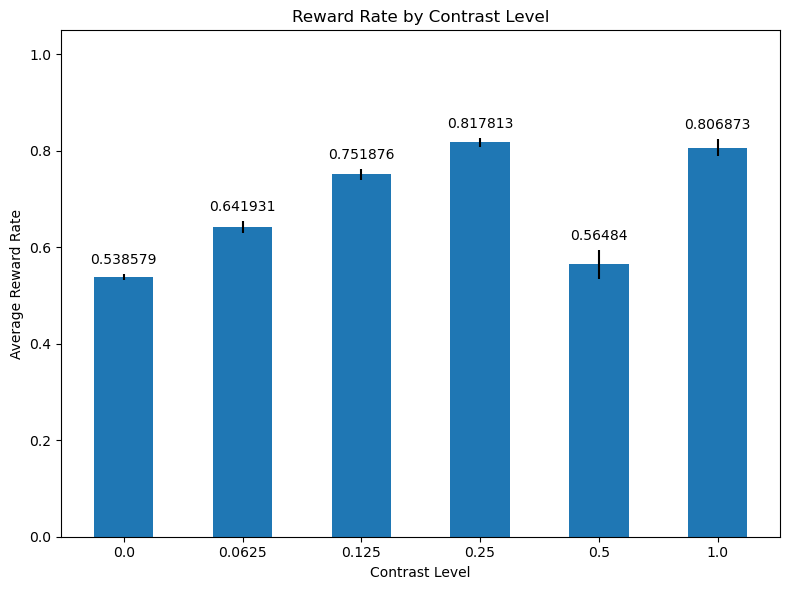

In [72]:
x = np.arange(len(contrasts))  # the label locations
width = 0.5  # width of bars
multiplier = 0

fig, ax = plt.subplots(figsize=(8, 6))

offset = width * multiplier
rects = ax.bar(x + offset, means, width, label=contrasts, yerr=errors)
ax.bar_label(rects, padding=5)
multiplier += 1
ax.set_xticks(x + offset, contrasts)

plt.title('Reward Rate by Contrast Level')
plt.xlabel('Contrast Level')
plt.ylabel('Average Reward Rate')
plt.ylim(0, 1.05)  # Adjust if needed
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


slope (95%): 155.593248 +/- 72.504531
intercept (95%): 41.828577 +/- 33.728735
R-squared: 0.939567


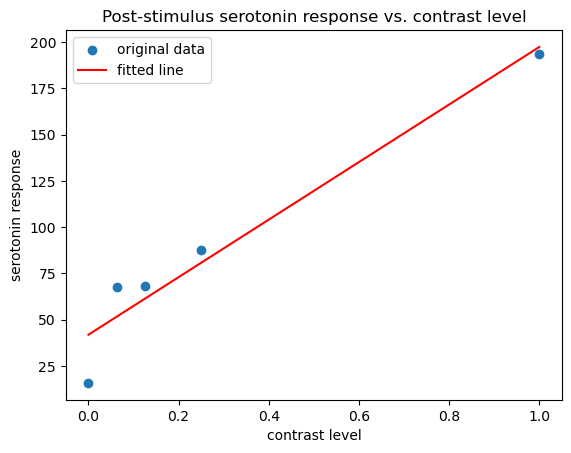

In [97]:
# get_best_fit_line(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', params=params)
plot_best_fit_line(eid='b387dd2b-61c4-4e2f-9572-389d40f93fc3', events='stimOn_times')

### For sessions that passed QC, fit linear regression for even 500ms response window

In [98]:
slopes1 = []
ci_slopes1 = []
r_squared1 = []
contrast1 = []
responses1 = []
idx = 0

for eid in eid_qcd:
    results = get_best_fit_line(eid, params=params, events='stimOn_times')
    if results is not None:
        slope1 = results[0]
        ci_slope1 = results[2]
        r_sqr1 = results[4]
        contrast = results[5]
        response1 = results[6]
        slopes1.append(slope1)
        ci_slopes1.append(ci_slope1)
        r_squared1.append(r_sqr1)
        contrast1.append(contrast)
        responses1.append(response1)
        print(f'completed session {idx + 1}/160 with eid {eid}')
    idx += 1
        
print(f'slopes: {slopes1}')
print(f'responses: {responses1}')

Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
slope (95%): 20.491250 +/- 510.212499
intercept (95%): 10.680621 +/- 337.473847
R-squared: 0.206611
completed session 8/160 with eid e04536b2-b161-478e-af3a-d04bc1ab33ee
Skipping session with less than three contrast levels.
slope (95%): -17.468480 +/- 176.616615
intercept (95%): 16.924199 +/- 116.820910
R-squared: 0.612306
completed session 10/160 with eid 9557f20a-e1ef-44d5-9859-20d1c3854175
Skipping session with less than three contrast levels.
slope (95%): 26.473637 +/- 24.138966
intercept (95%): 38.243685 +/- 15.966425
R-squared: 0.994877
completed session 12/160 with eid 4edc1662-a165-48ef-a332-7172bfc

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 152/160 with eid 385d2bc7-02e6-4d65-b20a-68ea9bd85e7c


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 153/160 with eid 8a328917-6ce3-4a8e-8d97-a21456187702


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 154/160 with eid 9c86d1db-cb3f-4bfe-bdd4-450c25b1b779
slope (95%): 11.122129 +/- 34.096289
intercept (95%): 22.476470 +/- 15.861418
R-squared: 0.264285
completed session 155/160 with eid b46d38e4-cba5-4d2f-b975-93542a452317
slope (95%): 10.550088 +/- 29.019360
intercept (95%): 6.681138 +/- 13.499657
R-squared: 0.308537
completed session 156/160 with eid 24415d91-8a3a-440b-beee-2d4388a4b908
slope (95%): 12.762163 +/- 34.749006
intercept (95%): 8.848873 +/- 16.165059
R-squared: 0.312890
completed session 157/160 with eid 61073b6e-842e-440e-bf59-b3197065bfa1
slope (95%): 89.908510 +/- 48.479988
intercept (95%): 75.657716 +/- 22.552641
R-squared: 0.920705
completed session 158/160 with eid a196fce9-7eae-4c11-ae01-25a9aa59b593
slope (95%): 71.969661 +/- 123.047681
intercept (95%): 100.046203 +/- 57.241148
R-squared: 0.535946
completed session 159/160 with eid 933765b5-1f4e-4877-b889-7cc87f6ddb64
slope (95

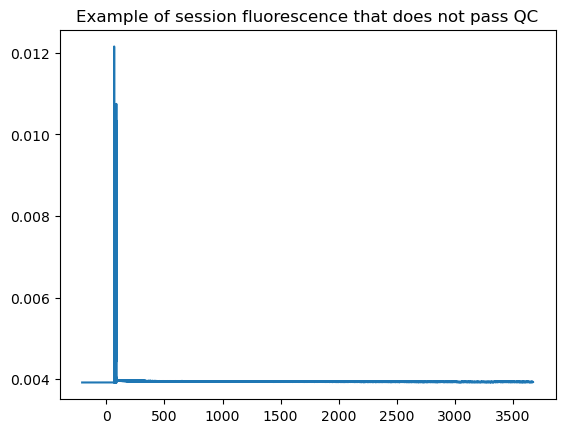

In [24]:
# confirm bad signal by plotting raw photometry data
%matplotlib inline
eid_sus = '16aa7570-578f-4daa-8244-844716fb1320'
phot_signal = load_photometry(eid_sus).values
phot_times = load_photometry(eid_sus).index
plt.plot(phot_times, phot_signal)
plt.title('Example of session fluorescence that does not pass QC')
# plt.ylim(0, 0.01)
plt.show()

In [99]:
# t-test
filtered_slopes1 = [s for s, r2 in zip(slopes1, r_squared1) if (r2 > 0)]
print(f'filtered slopes: {filtered_slopes1}')

# check to make sure the 10e3 cutoff is ok (confirmed, just needed to filter out the one that is 2e4, rest is much larger)
large_slopes = [s for s, r2 in zip(slopes1, r_squared1) if (s > 1e4)]
print(f'large slopes: {large_slopes}')

# Perform a one-sample t-test against 0
t_stat, p_two_tailed = stats.ttest_1samp(filtered_slopes1, popmean=0)

# Convert to one-tailed p-value for testing if mean > 0
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print(f'mean slope: {np.nanmean(filtered_slopes1)}')
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value (testing if mean > 0): {p_one_tailed}")

filtered slopes: [np.float64(20.491249507062676), np.float64(-17.46847959813986), np.float64(26.473637205060513), np.float64(-82.0280964159058), np.float64(-85.22020348735977), np.float64(81.63642992499231), np.float64(20.834205342520914), np.float64(147.62922610618136), np.float64(54.168381607212595), np.float64(-15.633979343528408), np.float64(-122.76536403310428), np.float64(86.44577831706978), np.float64(-104.18630547897318), np.float64(-11.081463878837305), np.float64(-24.14707882399411), np.float64(55.49662251000717), np.float64(13.57752901769762), np.float64(188.31014896635233), np.float64(-170.32639163696027), np.float64(101.56997612117055), np.float64(85.54991448969089), np.float64(93.95547688817314), np.float64(28.183848645192825), np.float64(-80.2795966082107), np.float64(103.69283967360442), np.float64(33.92078971686158), np.float64(24.594005790298763), np.float64(5.547075717559037), np.float64(175.92933976410686), np.float64(-25.46767248036451), np.float64(129.073965702211

In [100]:
# One-way ANOVA

from scipy.stats import f_oneway

filter_idx = [i for i, (s, r2) in enumerate(zip(slopes1, r_squared1)) if (r2 > 0)]
filtered_responses1 = [r for i, r in enumerate(responses1) if i in filter_idx]
# defective_idx = [i for i, s in enumerate(slopes1) if (s < -1e4) or (s > 1e4)]

group1 = [lst[0] for lst in filtered_responses1]
group2 = [lst[1] for lst in filtered_responses1]
group3 = [lst[2] for lst in filtered_responses1]
group4 = [lst[3] for lst in filtered_responses1 if len(lst)>3]
group5 = [lst[4] for lst in filtered_responses1 if len(lst)>4]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(group1, group2, group3, group4, group5)

print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.11f}")

F-statistic: 3.038371
P-value: 0.01698081777


In [118]:
slope_df = pd.DataFrame(filtered_slopes1, columns=['slope'])

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1008542099.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=slope_df, x='slope', bins=30,


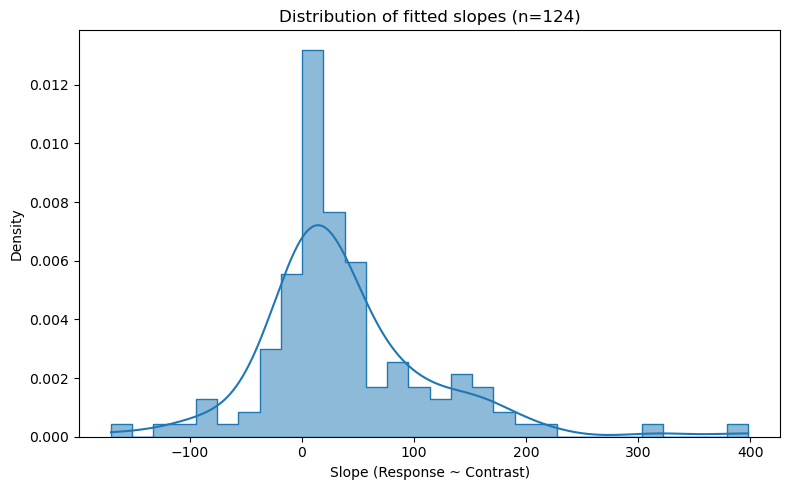

In [119]:
plt.figure(figsize=(8, 5))
sns.histplot(data=slope_df, x='slope', bins=30,
             kde=True, palette='muted', element='step', stat='density', common_norm=False)
plt.title(f'Distribution of fitted slopes (n={len(filtered_slopes1)})')
plt.xlabel("Slope (Response ~ Contrast)")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of fitted slopes (n=124)')

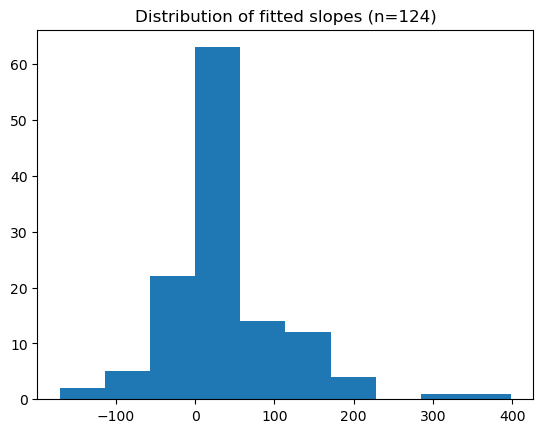

In [107]:
plt.hist(filtered_slopes1, bins=10)
plt.title(f'Distribution of fitted slopes (n={len(filtered_slopes1)})')

### Run the same analysis but with 1s or 2s response window depending on the contrast level

In [108]:
slopes = []
ci_slopes = []
r_squared = []
contrast = []
responses = []
idx = 0

for eid in eid_qcd:
    results = get_best_fit_line(eid, params=params, events='stimOn_times', protocol=1)
    if results is not None:
        slope = results[0]
        ci_slope = results[2]
        r_sqr = results[4]
        contrast = results[5]
        response = results[6]
        slopes.append(slope)
        ci_slopes.append(ci_slope)
        r_squared.append(r_sqr)
        contrast.append(contrast)
        responses.append(response)
        print(f'completed session {idx + 1}/160 with eid {eid}')
    idx += 1
        
print(f'slopes: {slopes}')
print(f'responses: {responses}')

Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
Skipping session with less than three contrast levels.
slope (95%): 76.853207 +/- 757.556650
intercept (95%): 11.710645 +/- 501.076625
R-squared: 0.624286
completed session 8/160 with eid e04536b2-b161-478e-af3a-d04bc1ab33ee
Skipping session with less than three contrast levels.
slope (95%): -38.896052 +/- 599.160583
intercept (95%): 96.304052 +/- 396.307474
R-squared: 0.404899
completed session 10/160 with eid 9557f20a-e1ef-44d5-9859-20d1c3854175
Skipping session with less than three contrast levels.
slope (95%): 23.792843 +/- 242.269555
intercept (95%): 111.633375 +/- 160.246248
R-squared: 0.608938
completed session 12/160 with eid 4edc1662-a165-48ef-a332-7172

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 152/160 with eid 385d2bc7-02e6-4d65-b20a-68ea9bd85e7c


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 153/160 with eid 8a328917-6ce3-4a8e-8d97-a21456187702


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

slope (95%): nan +/- nan
intercept (95%): nan +/- nan
R-squared: nan
completed session 154/160 with eid 9c86d1db-cb3f-4bfe-bdd4-450c25b1b779
slope (95%): 23.775925 +/- 48.068912
intercept (95%): 30.336605 +/- 22.361410
R-squared: 0.452336
completed session 155/160 with eid b46d38e4-cba5-4d2f-b975-93542a452317
slope (95%): 11.521997 +/- 25.958117
intercept (95%): 20.198903 +/- 12.075582
R-squared: 0.399448
completed session 156/160 with eid 24415d91-8a3a-440b-beee-2d4388a4b908
slope (95%): 9.688698 +/- 30.217944
intercept (95%): 13.640089 +/- 14.057232
R-squared: 0.257641
completed session 157/160 with eid 61073b6e-842e-440e-bf59-b3197065bfa1
slope (95%): 112.317819 +/- 86.769522
intercept (95%): 128.617489 +/- 40.364735
R-squared: 0.849776
completed session 158/160 with eid a196fce9-7eae-4c11-ae01-25a9aa59b593
slope (95%): 85.962259 +/- 125.100519
intercept (95%): 175.831109 +/- 58.196117
R-squared: 0.614500
completed session 159/160 with eid 933765b5-1f4e-4877-b889-7cc87f6ddb64
slope 

In [109]:
# t-test 
filtered_slopes = [s for s, r2 in zip(slopes, r_squared) if (r2 > 0)]
print(f'filtered slopes: {filtered_slopes}')

# check to make sure the 10e3 cutoff is ok (confirmed, just needed to filter out the one that is 2e4, rest is much larger)
large_slopes = [s for s, r2 in zip(slopes, r_squared) if (s > 1e4)]
print(f'large slopes: {large_slopes}')

# Perform a one-sample t-test against 0
t_stat, p_two_tailed = stats.ttest_1samp(filtered_slopes, popmean=0)

# Convert to one-tailed p-value for testing if mean > 0
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print(f'mean slope: {np.nanmean(filtered_slopes)}')
print(f"t-statistic: {t_stat:.4f}")
print(f"One-tailed p-value (testing if mean > 0): {p_one_tailed}")

filtered slopes: [np.float64(76.85320674821665), np.float64(-38.8960517671277), np.float64(23.7928429991406), np.float64(-111.6153794806574), np.float64(-241.08979919247903), np.float64(90.18777961380492), np.float64(34.43832761372261), np.float64(247.90338098748626), np.float64(50.262828630836054), np.float64(21.650163354536193), np.float64(-120.60279889375566), np.float64(176.41077456824414), np.float64(-209.68009057112332), np.float64(140.7090500632495), np.float64(-20.3373286106526), np.float64(93.65192155546215), np.float64(-9.68089751336166), np.float64(294.92865426605863), np.float64(-92.16088650891604), np.float64(174.18200040706196), np.float64(162.67375688330014), np.float64(169.55723896886246), np.float64(78.99673687048713), np.float64(-138.01007810373503), np.float64(102.37570227033659), np.float64(128.81742157104492), np.float64(55.102668196771496), np.float64(5.957008889357335), np.float64(122.6560266071142), np.float64(-23.039005661050574), np.float64(126.62536942683764)

In [ ]:
# One-way ANOVA

from scipy.stats import f_oneway

filter_idx = [i for i, (s, r2) in enumerate(zip(slopes, r_squared)) if (r2 > 0.75)]
filtered_responses = [r for i, r in enumerate(responses) if i in filter_idx]
# defective_idx = [i for i, s in enumerate(slopes1) if (s < -1e4) or (s > 1e4)]

group1 = [lst[0] for lst in filtered_responses]
group2 = [lst[1] for lst in filtered_responses]
group3 = [lst[2] for lst in filtered_responses]
group4 = [lst[3] for lst in filtered_responses if len(lst)>3]
group5 = [lst[4] for lst in filtered_responses if len(lst)>4]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(group1, group2, group3, group4, group5)

print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.11f}")

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2159399039.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=slope_df, x='slope', bins=30,


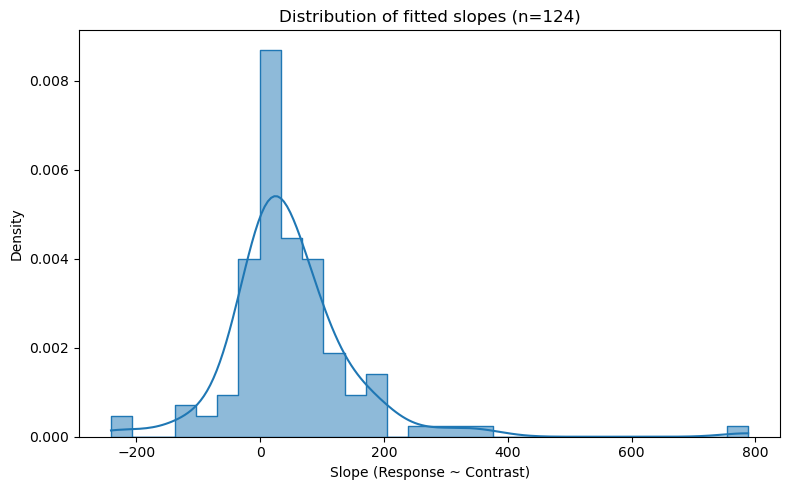

In [120]:
slope_df = pd.DataFrame(filtered_slopes, columns=['slope'])
plt.figure(figsize=(8, 5))
sns.histplot(data=slope_df, x='slope', bins=30,
             kde=True, palette='muted', element='step', stat='density', common_norm=False)
plt.title(f'Distribution of fitted slopes (n={len(filtered_slopes)})')
plt.xlabel("Slope (Response ~ Contrast)")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of fitted slopes (n=124)')

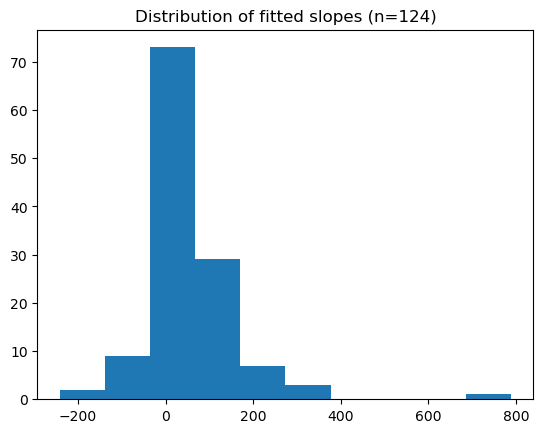

In [110]:
plt.hist(filtered_slopes, bins=10)
plt.title(f'Distribution of fitted slopes (n={len(filtered_slopes)})')

### Adjust response window by reaction time

In [121]:
def reaction_time_with_contrast(trials, events):

    # Define reaction time as the time elapsed between event of interest and stimulus onset
    reaction_time = trials[events] - trials['stimOn_times']

    # define the contrast levels
    contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

    # store result for each
    results = np.zeros(len(contrast_levels))
    idx = 0

    for contrast in contrast_levels:
        trial_idx = trials[(trials['contrastLeft']==contrast) | (trials['contrastRight']==contrast)].index
        result = np.nanmean(reaction_time[trial_idx])
        results[idx] = result
        idx += 1
        # print(f'\nAverage reaction time for contrast level {contrast} is {result:.4f}.')
    
    return results

In [ ]:
# define the contrast levels
contrast_levels = [0, 0.0625, 0.125, 0.25, 1]

# store results array
results_array = np.zeros([len(eid_qcd), len(contrast_levels)])
idx = 0

for trial in eid_qcd:
    test_df = load_trials(trial)
    results_array[idx, :] = reaction_time_with_contrast(test_df, 'response_times')
    idx += 1

# compute the mean and standard deviation for each contrast level
reaction_time_avg = np.nanmean(results_array, axis=0)
reaction_time_sem = stats.sem(results_array, axis=0, nan_policy='omit')
reaction_time_med = np.nanmedian(results_array, axis=0)
# q75, q25 = np.percentile(results_array, [75 ,25], axis=0)
# reaction_time_iqr = q75 - q25
reaction_time_max = np.max(results_array, axis=0)
reaction_time_min = np.min(results_array, axis=0)


def nan_iqr_axis0(data):
    # Ensure input is a NumPy array
    data = np.asarray(data)
    
    # Initialize output array
    iqr = np.empty(data.shape[1])
    
    for col in range(data.shape[1]):
        col_data = data[:, col]
        clean_col = col_data[~np.isnan(col_data)]
        q75, q25 = np.percentile(clean_col, [75, 25])
        iqr[col] = q75 - q25
    
    return iqr

iqr = nan_iqr_axis0(results_array)

print(f'median reaction time for each of the contrast levels is {reaction_time_med}.')
print(f'IQR of the reaction time for each of the contrast levels is {iqr}.')

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx]

median reaction time for each of the contrast levels is [2.8835557  2.35572567 1.79288064 1.44708647 1.02199841].
IQR of the reaction time for each of the contrast levels is [3.11652755 2.61816362 2.41148642 2.19461225 2.29451409].


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3877493975.py:15: RuntimeWarning: Mean of empty slice
  result = np.nanmean(reaction_time[trial_idx])


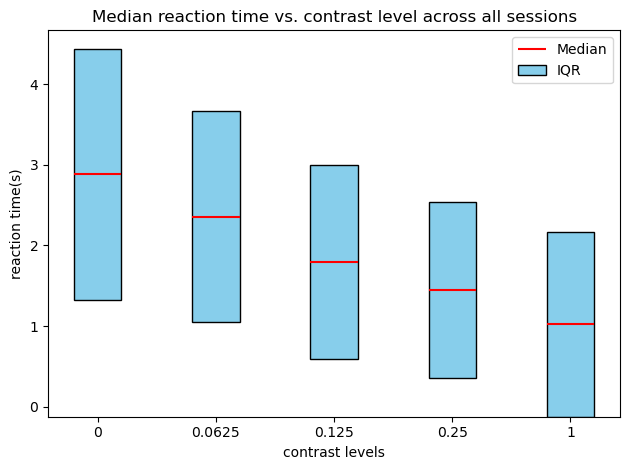

In [133]:
# plot for visualization

q1s = [m - iqr/2 for m, iqr in zip(reaction_time_med, iqr)]
q3s = [m + iqr/2 for m, iqr in zip(reaction_time_med, iqr)]

x = np.arange(len(contrast_levels))

# Plot the IQR box
plt.bar(x, iqr, bottom=q1s, width=0.4, color='skyblue', edgecolor='k', label='IQR')

# Plot the median as a horizontal line
plt.hlines(reaction_time_med, x - 0.2, x + 0.2, color='red', label='Median')

plt.xticks(x, contrast_levels)
plt.ylabel('reaction time(s)')
plt.xlabel('contrast levels')
plt.title('Median reaction time vs. contrast level across all sessions')
plt.legend()
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots()
# ax.bar(contrast_levels, reaction_time_med, width=3, color='skyblue', edgecolor='black')
# yerr = np.array(iqr) / 2
# ax.errorbar(contrast_levels, reaction_time_med, yerr=yerr)
# ax.set_xlabel('contrast level')
# ax.set_ylabel('reaction time(s)')
# ax.set_ylim(0, 4)
# ax.set_title('Average reaction time vs. contrast level across all sessions')
# plt.tight_layout()
# plt.show()



## Compare response at feedback times for various contrast levels

In [ ]:
# find the eids of sessions that have defective data based on the fitted slopes

valid = []

for eid in all_samples:
    if len(load_trials(eid)['contrastLeft'].unique()) <= 3:
        valid.append(False)
    else:
        valid.append(True)

invalid_idx = [i for i, b in enumerate(valid) if b is False]
invalid_idx # indices for sessions in all_samples where contrast levels are less than or equal to 3, so we skipped
defective_idx # indices for sessions in sessions that were run (so not including those skipped) which have defective data


# Step 1: Construct list of valid indices
valid_idx = [i for i in range(len(all_samples)) if i not in invalid_idx]

# Step 2: Map defective_idx to original all_samples indices
defective_in_all = [valid_idx[i] for i in defective_idx]

# Step 3 (optional): Get their IDs
defective_ids = [all_samples[i] for i in defective_in_all]

defective_ids

# make a new list of all the good samples
better_samples = [eid for eid in all_samples if eid not in defective_ids]
better_samples

['fe2a712b-014b-47e7-b2ac-f85d0571cf44',
 'ba01bf35-8a0d-4ca3-a66e-b3a540b21128',
 'f2a6559d-1e45-4e83-8f65-1295ef50ed4b',
 'c5cdd496-7400-4c0f-b326-55016bce4fcf',
 'fd22820d-a2c2-4c06-b90e-f399344e1c0a',
 '92bf91b5-75db-4e95-8623-fd32c615558f',
 '272c7a84-1f76-4305-a355-4e2149726a9d',
 '48c4f78b-92f7-4ee2-b9c1-5f807197b5e9',
 'e04536b2-b161-478e-af3a-d04bc1ab33ee',
 'df775d7e-3890-4aa3-b7ef-0c6fe6f9abf8',
 '9557f20a-e1ef-44d5-9859-20d1c3854175',
 '26d6c415-23b0-4c49-b73e-b6cf2693df4d',
 '4edc1662-a165-48ef-a332-7172bfca71e7',
 '38c3ebde-c45d-442e-ac61-f42161cfc984',
 'dd549116-68a1-462d-90ef-f4e0ec5c69fc',
 '32eaad6d-fd35-46e9-b7cb-22656d8e3375',
 '68f894bf-2268-4773-aa8d-ac8ab168320e',
 '72e564aa-8416-48fb-a2b9-f9d23e6c7e4b',
 'e9bdcf2b-d0db-42f8-8dfe-3bb82711ff68',
 'a44f72af-755f-4d58-b9bb-c5b345bcd788',
 'f869242e-d1f9-4b7e-a83d-7c794ca6ebbe',
 '4aaa7935-f74d-4797-a26d-598448328795',
 '929662b6-4182-4ee7-8a50-ec788520c9e2',
 '8d9a50bf-8ec7-41f6-a435-de88a6176b06',
 'db7b2ae8-4c68-

In [ ]:
eid = metadf_qcd['eid'][20]
session_rand = Photometry(eid, trial_idx=[0, 90])
session_rand.load_trials()
psth, ts, cont = session_rand.get_psth('stimOn_times', params=params, contrast=[1, 0.125, 0.25])
cont

{0.125: array([116.57472846,  86.46269433,  71.74837172,  72.95111355,
         63.72597195,  54.09105405,  46.1024968 ,  38.88194481,
         40.57091927,   4.03029829,  10.13167474,  46.15145721,
         32.09821716,  47.82685232,  34.22095269,  26.81832737,
          3.54941102, -11.35490472,  -2.88225538,  10.06816011,
         10.04842584,  11.35845565,  15.40308021,  22.50191824,
         35.04844767,  54.76571792,  29.12837473,  21.95435109,
         35.54715755,  48.87921573,  67.26837514,  46.90242301,
         70.48214704,  95.92119363,  82.27940241,  54.21825518,
         62.01630244,  66.54943854,  62.12188984,  86.38054004,
        114.62699934, 116.61641582,  93.22979178,  89.1662427 ,
         55.60093529,  46.51186132,  49.41856464,  38.58778311,
         27.16740042,   2.26413808,   3.96965417,  10.2455633 ,
          4.24046281,  28.37027492,  46.19546976,  89.35509149,
         68.72090806,  96.20799176,  95.85067649,  92.61630415]),
 0.25: array([ 78.06056516,  79

In [86]:
def reward_prediction_error(eid, params, events, trial_block=0):
    
    if trial_block==0:
        session = Photometry(eid)
    
    elif trial_block==1:
        session = Photometry(eid, trial_idx=[0, 90])

    else: 
        length = load_trials(eid).shape[0]
        session = Photometry(eid, trial_idx=[91, length])

    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()
    # print(contrast_levels)

    # compute the response for each contrast level
    psth_crct, tscale, psth_contrast_crct = session.get_psth(events=events, params=params, contrast=contrast_levels, feedback_type=1.0)
    psth_incrct, tscale, psth_contrast_incrct = session.get_psth(events=events, params=params, contrast=contrast_levels, feedback_type=-1.0)
    time_onset = np.searchsorted(tscale, 0)
    
    idx = 0
    contrast_levels = [0, 0.0625, 0.125, 0.25, 0.5, 1]
    response = np.zeros((len(contrast_levels), 2))

    # average response for the 500ms after event 
    for c_l in contrast_levels:
        if psth_contrast_crct.get(c_l) is None and psth_contrast_incrct.get(c_l) is None:
            response[idx] = None
        elif psth_contrast_crct.get(c_l) is not None and psth_contrast_incrct.get(c_l) is None:
            time_period = int(np.floor(0.5 / params.bin_size))
            crct_response_mag = np.nanmean(psth_contrast_crct.get(c_l)[time_onset:time_onset + time_period])
            response[idx] = crct_response_mag, None
        else:
            time_period = int(np.floor(0.5 / params.bin_size))
            crct_response_mag = np.nanmean(psth_contrast_crct.get(c_l)[time_onset:time_onset + time_period])
            incrct_response_mag = np.nanmean(psth_contrast_incrct.get(c_l)[time_onset:time_onset + time_period])
            response[idx] = crct_response_mag, incrct_response_mag
            # print(f"response magnitude for contrast level {c_l} is {response_mag}.")
        idx += 1

    # returns response
    return contrast_levels, response

In [ ]:
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
cl, res = reward_prediction_error('9d9c2211-3a55-4556-8bf8-b36d2f2deaf1', params=params, events='feedback_times')
cat = [str(level) for level in cl]
response_means = {
    'correct': res[:, 0], 
    'incorrect': res[:, 1]
}

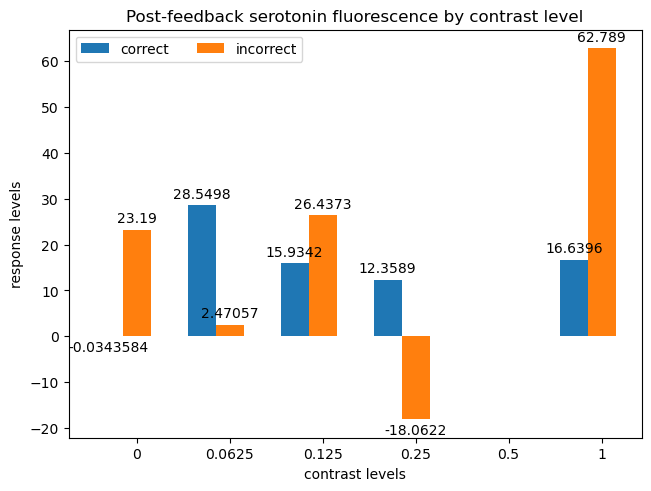

In [ ]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper left', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


In [ ]:
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
cl, res = reward_prediction_error('20fb5a24-a1b0-4538-803c-cf13eaff2af6', params=params, events='feedback_times')
cat = [str(level) for level in cl]
response_means = {
    'correct': res[:, 0], 
    'incorrect': res[:, 1]
}
response_means

{'correct': array([22.1619137 , 19.48061594,  6.30186949, 24.94904281,         nan,
         8.86086691]),
 'incorrect': array([-20.27369643,  -0.08960396, -10.81714338,  12.69963306,
                 nan,  32.54896747])}

In [40]:
print('20fb5a24-a1b0-4538-803c-cf13eaff2af6' in eid_qcd_high_performance)

True


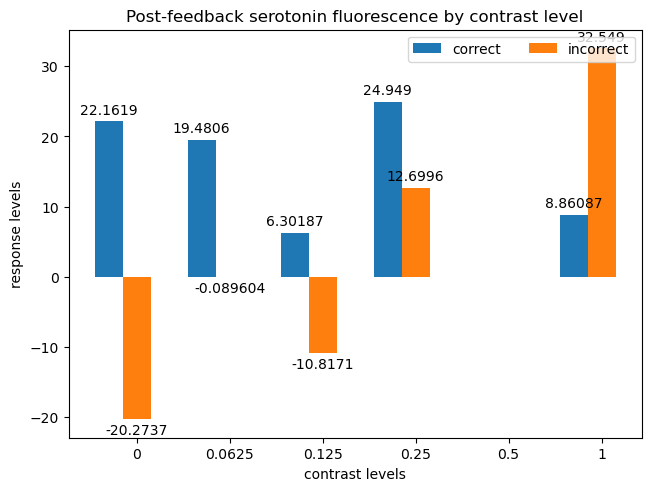

In [ ]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper right', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


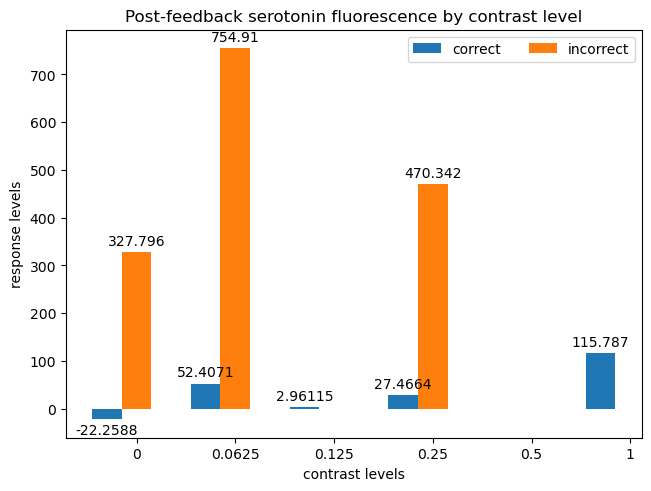

In [87]:
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
cl, res = reward_prediction_error(eid_qcd[50], params=params, events='feedback_times')
cat = [str(level) for level in cl]
response_means = {
    'correct': res[:, 0], 
    'incorrect': res[:, 1]
}
response_means

x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# labels, title
ax.set_ylabel('response levels')
ax.set_title("Post-feedback serotonin fluorescence by contrast level")
ax.set_xticks(x + width, cat)
ax.legend(loc='upper right', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()

In [89]:
eid_qcd[50]

'b2f1186e-8c04-46c9-b4a7-e5e9785ff0ca'

In [ ]:
# using sessions that passed QC
bias_df = metadf_qcd[metadf_qcd['session_type']=='biased']
training_df = metadf_qcd[metadf_qcd['session_type']=='training']
bias_df

,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
45,148,b387dd2b-61c4-4e2f-9572-389d40f93fc3,ZFM-03059,2021-10-05T17:50:54.880339,_iblrig_NPH_tasks_biasedChoiceWorld,biased,32,5HT,[DR],[Region1G]
47,151,46f4232d-eaed-4e99-9302-4a216c07fd29,ZFM-03059,2021-10-07T09:03:19.196823,_iblrig_NPH_tasks_biasedChoiceWorld6.5.0,biased,33,5HT,[DR],[Region1G]
49,156,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,ZFM-03059,2021-10-08T11:05:01.113163,_iblrig_NPH_tasks_biasedChoiceWorld6.5.0,biased,34,5HT,[DR],[Region1G]
50,157,f6d846da-6a63-4c5a-9d32-f572ef565e4f,ZFM-03059,2021-10-09T12:02:01.199654,_iblrig_NPH_tasks_biasedChoiceWorld6.5.0,biased,35,5HT,[DR],[Region1G]
51,162,8e90ac76-47c7-441b-b370-204a8002abd8,ZFM-03059,2021-10-11T10:04:28.799307,_iblrig_NPH_tasks_biasedChoiceWorld6.5.0,biased,36,5HT,[DR],[Region1G]
...,...,...,...,...,...,...,...,...,...,...
257,1809,24415d91-8a3a-440b-beee-2d4388a4b908,ZFM-05248,2023-08-17T07:09:21.348335,_iblrig_tasks_biasedChoiceWorld_ephyssessions,biased,89,5HT,[DR],[Region4G]
258,1818,61073b6e-842e-440e-bf59-b3197065bfa1,ZFM-05248,2023-08-18T08:25:24.087724,_iblrig_tasks_biasedChoiceWorld_ephyssessions,biased,90,5HT,[DR],[Region4G]
260,1836,a196fce9-7eae-4c11-ae01-25a9aa59b593,ZFM-05235,2023-08-23T06:51:52.029815,_iblrig_NPH_tasks_biasedChoiceWorld,biased,97,5HT,[DR],[Region3G]
261,1847,933765b5-1f4e-4877-b889-7cc87f6ddb64,ZFM-05235,2023-08-24T09:31:08.820731,_iblrig_NPH_tasks_biasedChoiceWorld,biased,98,5HT,[DR],[Region3G]


In [ ]:
# need to be available (in metadf) and also filter out defective sessions (in better_samples)
better_samples_bias = bias_df[(bias_df['eid'].isin(metadf['eid'])) & (bias_df['eid'].isin(better_samples))]
better_samples_bias

,subject,session_num,stage,eid,n_trials,n_correct,proportion_correct
24,ZFM-03059,25,bias,b387dd2b-61c4-4e2f-9572-389d40f93fc3,187,185,0.989305
25,ZFM-03059,26,bias,7f3b9633-851a-47e5-b7f8-c92bbbb01cc5,143,140,0.979021
29,ZFM-03059,30,bias,934798fb-006b-4cd4-a546-1b896aa4c212,212,209,0.985849
30,ZFM-03059,31,bias,d6629588-d238-4433-ad46-8ab6feb4cd0a,31,29,0.935484
33,ZFM-03059,34,bias,075a551f-ae82-4b9a-b659-fe94b638b7aa,100,92,0.920000
...,...,...,...,...,...,...,...
575,ZFM-05248,65,bias,65b43acb-afa5-4590-a400-f7f4c79788ab,182,170,0.934066
576,ZFM-05248,66,bias,9c86d1db-cb3f-4bfe-bdd4-450c25b1b779,262,239,0.912214
577,ZFM-05248,67,bias,b46d38e4-cba5-4d2f-b975-93542a452317,113,101,0.893805
578,ZFM-05248,68,bias,f416af34-121d-419c-8d27-4e95f8648012,168,161,0.958333


### Training sessions

In [ ]:
# training sessions
nsessions = training_df.shape[0]
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
all_responses = np.zeros((nsessions, 6, 2))
idx = 0

for eid in training_df['eid']:
    try: 
        cl, res = reward_prediction_error(eid, params=params, events='feedback_times')
        all_responses[idx] = res
        print(f'completed session {idx + 1}/{nsessions}.')
    except Exception as e:
        print(f"Skipping {eid} due to error: {e}")
        continue
    idx += 1

print(all_responses)

completed session 1/86.
completed session 2/86.
completed session 3/86.
completed session 4/86.
completed session 5/86.
completed session 6/86.
completed session 7/86.
completed session 8/86.
completed session 9/86.
completed session 10/86.
completed session 11/86.
completed session 12/86.
completed session 13/86.
completed session 14/86.
completed session 15/86.
completed session 16/86.
completed session 17/86.
completed session 18/86.
completed session 19/86.
completed session 20/86.
completed session 21/86.
completed session 22/86.
completed session 23/86.
completed session 24/86.
completed session 25/86.
completed session 26/86.
completed session 27/86.
completed session 28/86.
completed session 29/86.
completed session 30/86.
completed session 31/86.
completed session 32/86.
completed session 33/86.
completed session 34/86.
completed session 35/86.
completed session 36/86.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 37/86.
completed session 38/86.
completed session 39/86.
completed session 40/86.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 41/86.
completed session 42/86.
completed session 43/86.
completed session 44/86.
completed session 45/86.
completed session 46/86.
completed session 47/86.
completed session 48/86.
completed session 49/86.
completed session 50/86.
completed session 51/86.
completed session 52/86.
completed session 53/86.
completed session 54/86.
completed session 55/86.
completed session 56/86.
completed session 57/86.
completed session 58/86.
completed session 59/86.
completed session 60/86.


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/2743345707.py:244: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/2743345707.py:245: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/2743345707.py:247: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_87176/2743345707.py:248: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

completed session 61/86.
completed session 62/86.
completed session 63/86.
completed session 64/86.
completed session 65/86.
completed session 66/86.
completed session 67/86.
completed session 68/86.
completed session 69/86.
completed session 70/86.
completed session 71/86.
completed session 72/86.
completed session 73/86.
completed session 74/86.
completed session 75/86.
completed session 76/86.
completed session 77/86.
completed session 78/86.
completed session 79/86.
completed session 80/86.
completed session 81/86.
completed session 82/86.
completed session 83/86.
completed session 84/86.
completed session 85/86.
completed session 86/86.
[[[         nan          nan]
  [         nan          nan]
  [         nan          nan]
  [         nan          nan]
  [ 35.32783516  52.8656223 ]
  [ 48.42103026  39.61529428]]

 [[         nan          nan]
  [         nan          nan]
  [         nan          nan]
  [         nan          nan]
  [ 67.542107    96.11731846]
  [ 56.69073493  9

In [ ]:
# all_responses = all_responses[:idx]
res_mean = np.nanmean(all_responses, axis=0)
res_sem = stats.sem(all_responses, axis=0, nan_policy='omit')
print(res_mean, res_sem)

In [ ]:
cl = [0, 0.0625, 0.125, 0.25, 0.5, 1]
cat = [str(level) for level in cl]
response_means = {
    'correct': res_mean[:, 0], 
    'incorrect': res_mean[:, 1]
}
response_sem = {
    'correct': res_sem[:, 0], 
    'incorrect': res_sem[:, 1]
}

In [ ]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(figsize=(8, 6))
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=response_sem[attribute])
    ax.bar_label(rects, padding=5)
    multiplier += 1

# labels, title
ax.set_ylabel('response level (normalized)')
ax.set_title("Post-feedback-time gcamp response by contrast level for all trials")
ax.set_xticks(x + width, cat)
ax.legend(loc='lower right', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()

### Bias sessions

In [ ]:
# bias sessions
nsessions = bias_df.shape[0]
params = Params(pre_time=2, post_time=4, bin_size=0.1, baseline_time=0.2)
all_responses = np.zeros((nsessions, 6, 2))
idx = 0

for eid in bias_df['eid']:
    try: 
        cl, res = reward_prediction_error(eid, params=params, events='feedback_times')
        all_responses[idx] = res
        print(f'completed session {idx + 1}/{nsessions}.')
    except Exception as e:
        print(f"Skipping {eid} due to error: {e}")
        continue
    idx += 1

print(all_responses)

completed session 1/71.
completed session 2/71.
completed session 3/71.
completed session 4/71.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 5/71.
completed session 6/71.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 7/71.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 8/71.
completed session 9/71.
completed session 10/71.
completed session 11/71.
completed session 12/71.
completed session 13/71.
completed session 14/71.
completed session 15/71.
completed session 16/71.
completed session 17/71.
completed session 18/71.
completed session 19/71.
completed session 20/71.
completed session 21/71.
completed session 22/71.
completed session 23/71.
completed session 24/71.
completed session 25/71.
completed session 26/71.
completed session 27/71.
completed session 28/71.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 29/71.
completed session 30/71.
completed session 31/71.
completed session 32/71.
completed session 33/71.
completed session 34/71.
completed session 35/71.
completed session 36/71.
completed session 37/71.
completed session 38/71.
completed session 39/71.
completed session 40/71.
completed session 41/71.
completed session 42/71.
completed session 43/71.
completed session 44/71.
completed session 45/71.
completed session 46/71.
completed session 47/71.
completed session 48/71.
completed session 49/71.
completed session 50/71.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


completed session 51/71.
completed session 52/71.
completed session 53/71.
completed session 54/71.
completed session 55/71.
completed session 56/71.
completed session 57/71.
completed session 58/71.
completed session 59/71.
completed session 60/71.
completed session 61/71.
completed session 62/71.
completed session 63/71.
completed session 64/71.
completed session 65/71.
completed session 66/71.
completed session 67/71.
completed session 68/71.
completed session 69/71.
completed session 70/71.
completed session 71/71.
[[[-1.34349882e+02  2.39606909e+02]
  [-3.57983069e+01  1.43628315e+02]
  [-2.18156958e+01  2.40488495e+02]
  [-7.61061184e+00  2.07411917e+02]
  [            nan             nan]
  [ 6.56894845e+01  7.02065265e+02]]

 [[-1.29698684e+02  1.42815794e+02]
  [-7.68062999e+01  2.09484689e+02]
  [-6.05124034e+01  1.33649602e+02]
  [ 2.29219453e+01  2.12626582e+02]
  [            nan             nan]
  [ 6.96884555e+01  1.63236607e+02]]

 [[-1.49783243e+02  2.46535743e+02]
  [

In [ ]:
# all_responses = all_responses[:idx]
res_mean = np.nanmean(all_responses, axis=0)
res_sem = stats.sem(all_responses, axis=0, nan_policy='omit')
print(res_mean, res_sem)

[[106.43239912 121.08635591]
 [119.38648929 108.18255317]
 [120.79764613 106.43737367]
 [113.05141609  94.74352196]
 [ 78.31872429  80.28842124]
 [ 98.75269242  78.2181824 ]] [[20.74112749 16.49258949]
 [19.22688869 15.52322446]
 [18.27334246 16.66950207]
 [15.69536414 11.85448435]
 [14.96528485 14.22628115]
 [11.02090499 11.99475438]]


In [ ]:
cl = [0, 0.0625, 0.125, 0.25, 0.5, 1]
cat = [str(level) for level in cl]
response_means = {
    'correct': res_mean[:, 0], 
    'incorrect': res_mean[:, 1]
}
response_sem = {
    'correct': res_sem[:, 0], 
    'incorrect': res_sem[:, 1]
}

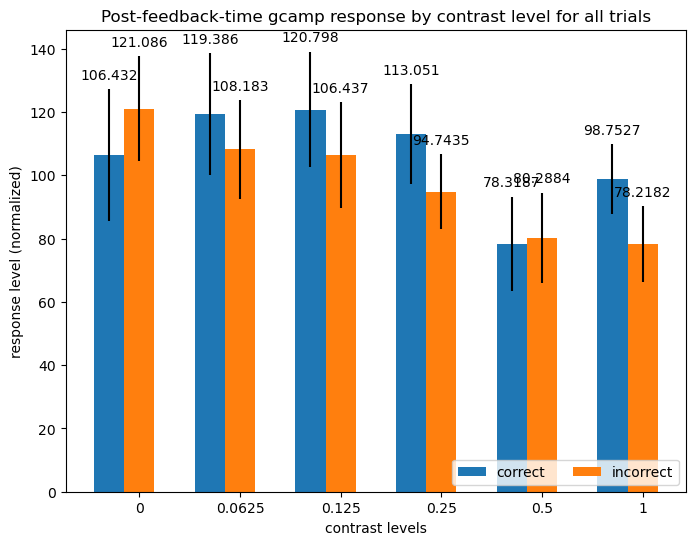

In [ ]:
x = np.arange(len(cat))  # the label locations
width = 0.3  # width of bars
multiplier = 0

fig, ax = plt.subplots(figsize=(8, 6))
for attribute, measurement in response_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=response_sem[attribute])
    ax.bar_label(rects, padding=5)
    multiplier += 1

# labels, title
ax.set_ylabel('response level (normalized)')
ax.set_title("Post-feedback-time gcamp response by contrast level for all trials")
ax.set_xticks(x + width, cat)
ax.legend(loc='lower right', ncols=2)
# ax.set_ylim(-250, 1800)
ax.set_xlabel('contrast levels')

plt.show()


## Select low contrast blocks

In [ ]:
import numpy as np

def low_contrast_blocks(eid, length=3, crit=[0]):
    '''
    Finds consecutive blocks where the trials are all low contrast
    -------------------
    Parameters:
    eid (str): eid of the session
    length (int): desired number of consecutive low-contrast trials 
    crit (lst): list of contrast levels that constitute "low contrast". 

    '''

    trials = load_trials(eid)
    contrast = trials['contrastLeft'].combine_first(trials['contrastRight'])
    trials['contrast'] = contrast # also store in dataFrame

    # Ensure contrast is a NumPy array
    contrast = np.array(contrast)

    # Make crit a set for fast membership testing
    crit_set = set(crit if isinstance(crit, (list, set, tuple)) else [crit])
    
    # Create boolean mask where contrast is in crit
    is_low = np.isin(contrast, list(crit_set))

    # Find change points in the boolean mask
    diff = np.diff(np.concatenate(([0], is_low.view(np.int8), [0])))
    start_idxs = np.where(diff == 1)[0]   # Run starts
    end_idxs = np.where(diff == -1)[0]    # Run ends

    # Filter runs by length
    valid_runs = [(start, end) for start, end in zip(start_idxs, end_idxs) if end - start >= length]
    
    return valid_runs
    
def longest_low_contrast_block(eid, length=3, crit=[0]):
    '''
    returns the length of the longest low contrast block
    '''
    
    valid_runs = low_contrast_blocks(eid, length, crit)
    max = 0

    for (start, end) in valid_runs: 
        length = end - start
        if length > max:
            max = length
    
    return max

def inter_trial_interval(eid): 
    ''' 
    returns the ITIs for a session
    '''
    trials = load_trials(eid)
    iti = np.diff(trials['goCue_times'])
    return iti

def trial_long(eid):
    '''
    returns the trial_ids that have ITIs greater than 7s. 
    '''
    lst = []
    iti = inter_trial_interval(eid)
    for trial_id, time in enumerate(iti):
        if time >= 7:
            lst.append(trial_id)
    return lst

In [ ]:
# eid = metadf['eid'][20]
# print(low_contrast_blocks(eid, crit=[0, 0.0625, 0.125, 0.25]))
# print(longest_low_contrast_block(eid, crit=[0, 0.0625, 0.125, 0.25]))

sessions = []
for eid in eid_qcd:
    block_length = longest_low_contrast_block(eid, length=12, crit=[0, 0.0625, 0.125])
    if block_length > 0:
        sessions.append(eid) 

len(sessions)
# so we have 47 sessions where there's at least one block which are 12 consecutive low 
# (0, 0.0625, 0.125) contrast trials! 

39

In [135]:
sessions
session_eg = sessions[10]

In [136]:
params=Params(pre_time=4, post_time=6, bin_size=0.1, baseline_time=0.5)
indices = low_contrast_blocks(session_eg, length=12, crit=[0, 0.0625, 0.125])

# list comprehension to flatten the list of tuples
trial_idx = [idx for tup in indices for idx in tup]
trial_idx

# # create Photometry object for this block
# block = Photometry(session_eg, trial_idx=trial_idx)
# block.load_photometry()
# block_psth, tscale = block.get_psth('feedback_times', params=params)
# time_onset = np.searchsorted(tscale, 0)
# # block.plot_psth('feedback_times', params=params)
# block_response = block_psth[time_onset : time_onset + 1]
# np.sum(block_response)


[np.int64(165), np.int64(177)]

#### test trial_psth

Mean signal for Trial165: 0.005580936374366694
Mean signal for Trial166: 0.005576008379385599
Mean signal for Trial167: 0.005578095600560848
Mean signal for Trial168: 0.005576720067981168
Mean signal for Trial169: 0.005571992422310584
Mean signal for Trial170: 0.005568347260974449
Mean signal for Trial171: 0.005569899220558902
Mean signal for Trial172: 0.0055653210892991556
Mean signal for Trial173: 0.005562471344628654
Mean signal for Trial174: 0.0055591102606730985
Mean signal for Trial175: 0.00556021965760148
Mean signal for Trial176: 0.005554729488435654
Mean signal for Trial177: 0.005556057176403855


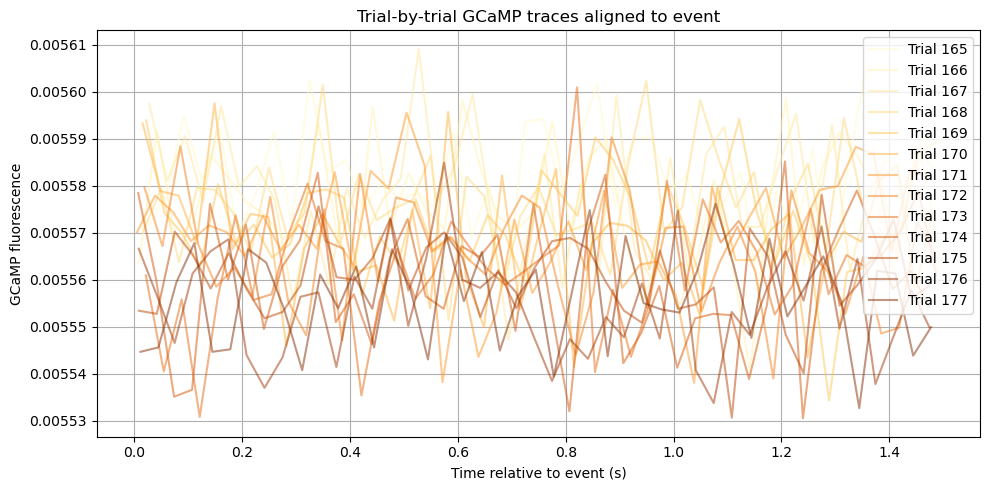

In [137]:
# session Photometry object
ind_trial_session = Photometry(session_eg)
ind_trial_session.trial_psth('feedback_times', trial_idx=int(trial_idx[0]), window=1.5)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot each trial's trace
plt.figure(figsize=(10, 5))
first_trial_idx = int(trial_idx[0])
last_trial_idx = int(trial_idx[1])
length_of_block = last_trial_idx - first_trial_idx + 1
palette = sns.color_palette("YlOrBr", n_colors=length_of_block)
idx = 0

for i in range(trial_idx[0], trial_idx[1] + 1):
    x = ind_trial_session.trial_psth('feedback_times', trial_idx=first_trial_idx + i, window=1.5)[0].index
    y = ind_trial_session.trial_psth('feedback_times', trial_idx=first_trial_idx + i, window=1.5)[0].values
    plt.plot(x, y, alpha=0.5, label=f'Trial {i}', c=palette[idx]) 
    idx += 1
    print(f'Mean signal for Trial{i}: {ind_trial_session.trial_psth("feedback_times", trial_idx=first_trial_idx + i, window=1.5)[1]}')

plt.legend()
plt.xlabel('Time relative to event (s)')
plt.ylabel('GCaMP fluorescence')
plt.title('Trial-by-trial GCaMP traces aligned to event')
plt.grid(True)
plt.tight_layout()
plt.show()

## RPE Statistics

### Function code

In [146]:
import statsmodels.api as sm
params = Params(baseline_time=0.2)

# Run linear regressions per session and correctness condition
def run_rpe_regressions(eid, protocol=0):

    session_df = pd.DataFrame(columns=['eid', 'contrast', 'correctness', 'response'])
    session = Photometry(eid)
    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()

    if len(contrast_levels) < 2: 
        print("Skipping session with less than two contrast levels.")
        return None

    # compute the response for each contrast level
    psth_contrast_crct = session.get_psth(events="feedback_times", params=params, contrast=contrast_levels, feedback_type=1.0)[2]
    tscale, psth_contrast_incrct = session.get_psth(events="feedback_times", params=params, contrast=contrast_levels, feedback_type=-1.0)[1:]
    time_onset = np.searchsorted(tscale, 0)
    
    # sum up 1s to 2s after event depending on contrast levels
    for c_l in contrast_levels:
       
        if protocol==0:
            time_period = int(np.floor(1.0 / params.bin_size))
        
        else:
            if c_l in contrast_levels[:2]:
                time_period = int(np.floor(2.0 / params.bin_size))
            else:
                time_period = int(np.floor(1.0 / params.bin_size))
        
        response_mag_crct = np.nanmean(psth_contrast_crct.get(c_l)[time_onset:time_onset + time_period])
        try:
            response_mag_incrct = np.nanmean(psth_contrast_incrct.get(c_l)[time_onset:time_onset + time_period])
        except:
            print('error occurred, possibly empty data, skipping this session.')
            continue
        session_df.loc[len(session_df)] = [eid, c_l, "correct", response_mag_crct]
        session_df.loc[len(session_df)] = [eid, c_l, "incorrect", response_mag_incrct]
    
    results = []
    
    for correctness in ['correct', 'incorrect']:
        subset = session_df[session_df['correctness'] == correctness]

        X = sm.add_constant(subset['contrast'])  # Add intercept
        y = subset['response']
        model = sm.OLS(y, X).fit()

        results.append({
            'session_id': eid,
            'correctness': correctness,
            'slope': model.params['contrast'],
            'intercept': model.params['const'],
            'r_squared': model.rsquared
        })

    return results, session_df

def get_session_df(eid, protocol=0): 

    session_df = pd.DataFrame(columns=['eid', 'contrast', 'response'])
    session = Photometry(eid)
    contrast_levels = session.contrastLeft.unique()
    contrast_levels = list(contrast_levels[~np.isnan(contrast_levels)])
    contrast_levels.sort()

    if len(contrast_levels) < 2: 
        print("Skipping session with less than two contrast levels.")
        return None

    # compute the response for each contrast level
    tscale, psth_contrast = session.get_psth(events="stimOn_times", params=params, contrast=contrast_levels)[1:]
    time_onset = np.searchsorted(tscale, 0)

    # sum up 1s to 2s after event depending on contrast levels
    for c_l in contrast_levels:
       
        if protocol==0:
            time_period = int(np.floor(0.5 / params.bin_size))
        
        else:
            if c_l in contrast_levels[:2]:
                time_period = int(np.floor(2.0 / params.bin_size))
            else:
                time_period = int(np.floor(1.0 / params.bin_size))
        
        response_mag = np.nanmean(psth_contrast.get(c_l)[time_onset:time_onset + time_period])
        session_df.loc[len(session_df)] = [eid, c_l, response_mag]

    return session_df
    

In [147]:
eid = eid_qcd[100]
run_rpe_regressions(eid)
get_session_df(eid)

,eid,contrast,response
0,7ffd404f-3ddd-46aa-99f0-e6db99cc5186,0.0000,-11.427221
1,7ffd404f-3ddd-46aa-99f0-e6db99cc5186,0.0625,-4.621024
2,7ffd404f-3ddd-46aa-99f0-e6db99cc5186,0.1250,-5.947859
3,7ffd404f-3ddd-46aa-99f0-e6db99cc5186,0.2500,-20.645964
4,7ffd404f-3ddd-46aa-99f0-e6db99cc5186,1.0000,-4.475230


In [168]:
all_results = []
all_sessions_df = pd.DataFrame(columns=['eid', 'contrast', 'correctness', 'response'])

for eid in eid_qcd:
    session_results, session_df = run_rpe_regressions(eid)
    all_results.extend(session_results)
    # List of new rows as DataFrames
    new_row = [pd.DataFrame(session_df, columns=all_sessions_df.columns)]
    # Concatenate the original DataFrame with the new rows
    all_sessions_df = pd.concat([all_sessions_df] + new_row, ignore_index=True)
    # print(session_df)

regression_results_df = pd.DataFrame(all_results)
print(regression_results_df)
print(all_sessions_df)

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1333017487.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_sessions_df = pd.concat([all_sessions_df] + new_row, ignore_index=True)


error occurred, possibly empty data, skipping this session.
error occurred, possibly empty data, skipping this session.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


error occurred, possibly empty data, skipping this session.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


error occurred, possibly empty data, skipping this session.
error occurred, possibly empty data, skipping this session.
error occurred, possibly empty data, skipping this session.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


error occurred, possibly empty data, skipping this session.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


error occurred, possibly empty data, skipping this session.


/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1194287946.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1194287946.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0, nan_policy='omit')
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1194287946.py:249: RuntimeWarning: Mean of empty slice
  self.__incorrect_psth = np.nanmean(dF_F[incorrect_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/1194287946.py:250: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. 

error occurred, possibly empty data, skipping this session.


/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sarahhu/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


                               session_id correctness     slope  intercept  \
0    fe2a712b-014b-47e7-b2ac-f85d0571cf44     correct  0.020648  -0.026139   
1    fe2a712b-014b-47e7-b2ac-f85d0571cf44   incorrect  0.001859  -0.007245   
2    ba01bf35-8a0d-4ca3-a66e-b3a540b21128     correct -0.000461   0.000077   
3    ba01bf35-8a0d-4ca3-a66e-b3a540b21128   incorrect  0.000053   0.001461   
4    f2a6559d-1e45-4e83-8f65-1295ef50ed4b     correct  0.009283  -0.023069   
..                                    ...         ...       ...        ...   
315  a196fce9-7eae-4c11-ae01-25a9aa59b593   incorrect -0.000294  -0.000688   
316  933765b5-1f4e-4877-b889-7cc87f6ddb64     correct  0.000157   0.001843   
317  933765b5-1f4e-4877-b889-7cc87f6ddb64   incorrect  0.000041  -0.000631   
318  20fb5a24-a1b0-4538-803c-cf13eaff2af6     correct -0.000091   0.000141   
319  20fb5a24-a1b0-4538-803c-cf13eaff2af6   incorrect  0.000633  -0.000178   

     r_squared  
0     1.000000  
1     1.000000  
2     1.0000

In [163]:
all_sessions_df1 = pd.DataFrame(columns=['eid', 'contrast', 'response'])

for eid in eid_qcd:
    session_df = get_session_df(eid, protocol=1)
    # List of new rows as DataFrames
    new_row = [pd.DataFrame(session_df, columns=all_sessions_df.columns)]
    # Concatenate the original DataFrame with the new rows
    all_sessions_df1 = pd.concat([all_sessions_df1] + new_row, ignore_index=True)
    # print(session_df)
print(all_sessions_df1)

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/3724687457.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_sessions_df1 = pd.concat([all_sessions_df1] + new_row, ignore_index=True)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:246: RuntimeWarning: Mean of empty slice
  self.__correct_psth = np.nanmean(dF_F[correct_idx], axis=0)
/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2062875056.py:247: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  self.__correct_psth_sem = stats.sem(dF_F[correct_idx], axis=0,

                                      eid  contrast    response  correctness  \
0    fe2a712b-014b-47e7-b2ac-f85d0571cf44    0.5000  146.935916          NaN   
1    fe2a712b-014b-47e7-b2ac-f85d0571cf44    1.0000  217.416796          NaN   
2    ba01bf35-8a0d-4ca3-a66e-b3a540b21128    0.5000   50.387377          NaN   
3    ba01bf35-8a0d-4ca3-a66e-b3a540b21128    1.0000   39.448213          NaN   
4    f2a6559d-1e45-4e83-8f65-1295ef50ed4b    0.5000  262.981298          NaN   
..                                    ...       ...         ...          ...   
675  20fb5a24-a1b0-4538-803c-cf13eaff2af6    0.0000    8.233935          NaN   
676  20fb5a24-a1b0-4538-803c-cf13eaff2af6    0.0625    6.166090          NaN   
677  20fb5a24-a1b0-4538-803c-cf13eaff2af6    0.1250    8.833988          NaN   
678  20fb5a24-a1b0-4538-803c-cf13eaff2af6    0.2500   24.761279          NaN   
679  20fb5a24-a1b0-4538-803c-cf13eaff2af6    1.0000   29.095821          NaN   

     contrast_cat  
0             NaN  

In [164]:
all_sessions_df1 = all_sessions_df1[['eid', 'contrast', 'response']]

In [165]:
all_sessions_df1[['response', 'contrast', 'eid']].isnull().sum()
all_sessions_df1 = all_sessions_df1.dropna(subset=['response'])
all_sessions_df1 = all_sessions_df1.reset_index(drop=True)
all_sessions_df1


,eid,contrast,response
0,fe2a712b-014b-47e7-b2ac-f85d0571cf44,0.5000,146.935916
1,fe2a712b-014b-47e7-b2ac-f85d0571cf44,1.0000,217.416796
2,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,0.5000,50.387377
3,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,1.0000,39.448213
4,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,0.5000,262.981298
...,...,...,...
658,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.0000,8.233935
659,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.0625,6.166090
660,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.1250,8.833988
661,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.2500,24.761279


In [166]:
import statsmodels.formula.api as smf

model = smf.mixedlm("response ~ contrast", 
                    data=all_sessions_df1, 
                    groups=all_sessions_df1["eid"])
result = model.fit()
print(result.pvalues)


Intercept    6.560235e-15
contrast     1.202145e-15
Group Var    1.448861e-13
dtype: float64


### linear regression results

In [169]:
regression_results_df

,session_id,correctness,slope,intercept,r_squared
0,fe2a712b-014b-47e7-b2ac-f85d0571cf44,correct,0.020648,-0.026139,1.000000
1,fe2a712b-014b-47e7-b2ac-f85d0571cf44,incorrect,0.001859,-0.007245,1.000000
2,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,correct,-0.000461,0.000077,1.000000
3,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,incorrect,0.000053,0.001461,1.000000
4,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,correct,0.009283,-0.023069,1.000000
...,...,...,...,...,...
315,a196fce9-7eae-4c11-ae01-25a9aa59b593,incorrect,-0.000294,-0.000688,0.173746
316,933765b5-1f4e-4877-b889-7cc87f6ddb64,correct,0.000157,0.001843,0.212485
317,933765b5-1f4e-4877-b889-7cc87f6ddb64,incorrect,0.000041,-0.000631,0.007672
318,20fb5a24-a1b0-4538-803c-cf13eaff2af6,correct,-0.000091,0.000141,0.262699


In [170]:
all_results

[{'session_id': 'fe2a712b-014b-47e7-b2ac-f85d0571cf44',
  'correctness': 'correct',
  'slope': np.float64(0.020647884981862336),
  'intercept': np.float64(-0.02613863429043752),
  'r_squared': np.float64(1.0)},
 {'session_id': 'fe2a712b-014b-47e7-b2ac-f85d0571cf44',
  'correctness': 'incorrect',
  'slope': np.float64(0.001859389348692712),
  'intercept': np.float64(-0.00724488801533535),
  'r_squared': np.float64(1.0)},
 {'session_id': 'ba01bf35-8a0d-4ca3-a66e-b3a540b21128',
  'correctness': 'correct',
  'slope': np.float64(-0.00046129890441244843),
  'intercept': np.float64(7.661777364117768e-05),
  'r_squared': np.float64(1.0)},
 {'session_id': 'ba01bf35-8a0d-4ca3-a66e-b3a540b21128',
  'correctness': 'incorrect',
  'slope': np.float64(5.292621748177412e-05),
  'intercept': np.float64(0.0014606302985678183),
  'r_squared': np.float64(1.0)},
 {'session_id': 'f2a6559d-1e45-4e83-8f65-1295ef50ed4b',
  'correctness': 'correct',
  'slope': np.float64(0.009282755970780751),
  'intercept': np

In [171]:
all_sessions_df

,eid,contrast,correctness,response
0,fe2a712b-014b-47e7-b2ac-f85d0571cf44,0.500,correct,-0.015815
1,fe2a712b-014b-47e7-b2ac-f85d0571cf44,0.500,incorrect,-0.006315
2,fe2a712b-014b-47e7-b2ac-f85d0571cf44,1.000,correct,-0.005491
3,fe2a712b-014b-47e7-b2ac-f85d0571cf44,1.000,incorrect,-0.005385
4,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,0.500,correct,-0.000154
...,...,...,...,...
1337,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.125,incorrect,-0.000049
1338,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.250,correct,0.000193
1339,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.250,incorrect,0.000071
1340,20fb5a24-a1b0-4538-803c-cf13eaff2af6,1.000,correct,0.000041


### Two-way ANOVA

In [140]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Make sure contrast is treated as categorical for ANOVA
all_sessions_df['contrast_cat'] = all_sessions_df['contrast'].astype(str)

# Two-way ANOVA
model = ols('response ~ C(correctness) * C(contrast_cat)', data=all_sessions_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                      sum_sq      df         F    PR(>F)
C(correctness)                  2.612019e+04     1.0  0.811216  0.367929
C(contrast_cat)                 9.363173e+04     5.0  0.581585  0.714163
C(correctness):C(contrast_cat)  6.529569e+04     5.0  0.405578  0.845166
Residual                        4.160085e+07  1292.0       NaN       NaN


### Mixed ANOVA

In [141]:
all_sessions_df[['response', 'correctness', 'contrast', 'eid']].isnull().sum()

response       38
correctness     0
contrast        0
eid             0
dtype: int64

In [145]:
all_sessions_df = all_sessions_df.dropna(subset=['response'])
all_sessions_df = all_sessions_df.reset_index(drop=True)
all_sessions_df

,eid,contrast,correctness,response,contrast_cat
0,fe2a712b-014b-47e7-b2ac-f85d0571cf44,0.500,correct,-96.351185,0.5
1,fe2a712b-014b-47e7-b2ac-f85d0571cf44,0.500,incorrect,-27.464565,0.5
2,fe2a712b-014b-47e7-b2ac-f85d0571cf44,1.000,correct,-65.173467,1.0
3,fe2a712b-014b-47e7-b2ac-f85d0571cf44,1.000,incorrect,-53.522365,1.0
4,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,0.500,correct,-12.977742,0.5
...,...,...,...,...,...
1299,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.125,incorrect,-3.715529,0.125
1300,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.250,correct,16.838629,0.25
1301,20fb5a24-a1b0-4538-803c-cf13eaff2af6,0.250,incorrect,5.222948,0.25
1302,20fb5a24-a1b0-4538-803c-cf13eaff2af6,1.000,correct,3.952922,1.0


In [143]:
all_sessions_df['eid'] = all_sessions_df['eid'].astype(str)
print("Unique groups:", all_sessions_df['eid'].nunique())
print("Data shape:", all_sessions_df.shape)


Unique groups: 156
Data shape: (1304, 5)


In [144]:
import statsmodels.formula.api as smf

model = smf.mixedlm("response ~ correctness * contrast",
                    data=all_sessions_df,
                    groups=all_sessions_df["eid"])

result = model.fit()
print(result.summary())


                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        response  
No. Observations:          1304           Method:                    REML      
No. Groups:                156            Scale:                     23058.3780
Min. group size:           4              Log-Likelihood:            -8498.6919
Max. group size:           12             Converged:                 Yes       
Mean group size:           8.4                                                 
-------------------------------------------------------------------------------
                                   Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                           31.034   11.560  2.685 0.007   8.377 53.690
correctness[T.incorrect]            -5.956   11.374 -0.524 0.601 -28.249 16.337
contrast                            26.967   16.223  1.662 0.

### Session-by-session plots

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_session_fit(session_df, regression_results):
    """
    Plot fluorescence response vs. contrast with regression lines for correct and incorrect trials
    for a single session.
    """
    session_id = session_df['eid'].iloc[0]
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot raw data
    sns.scatterplot(data=session_df, x='contrast', y='response',
                    hue='correctness', style='correctness', s=60, ax=ax)

    # Plot regression lines using slope/intercept from regression_results
    for condition in ['correct', 'incorrect']:
        row = next((r for r in regression_results if r['correctness'] == condition), None)
        if row is None:
            continue
        x_vals = np.linspace(session_df['contrast'].min(), session_df['contrast'].max(), 100)
        y_vals = row['intercept'] + row['slope'] * x_vals
        ax.plot(x_vals, y_vals, label=f'{condition} fit', linestyle='--')

    ax.set_title(f"Session: {session_id}")
    ax.set_ylabel("Fluorescence Response")
    ax.set_xlabel("Contrast Level")
    ax.legend()
    plt.tight_layout()
    plt.show()


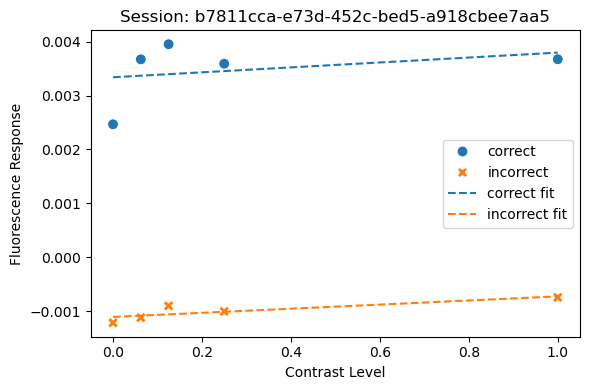

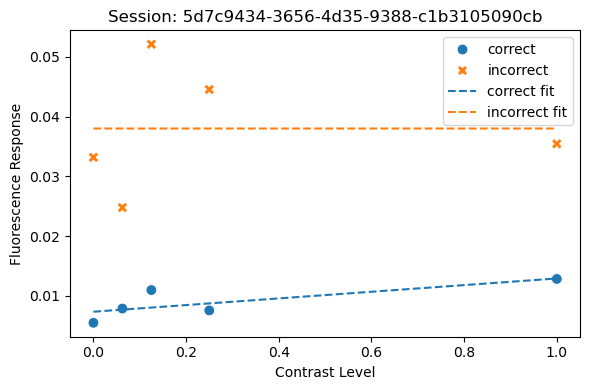

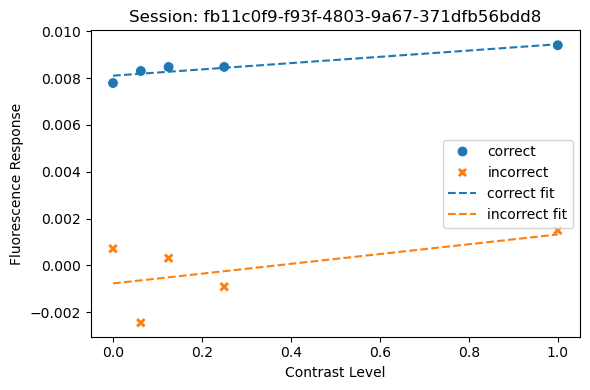

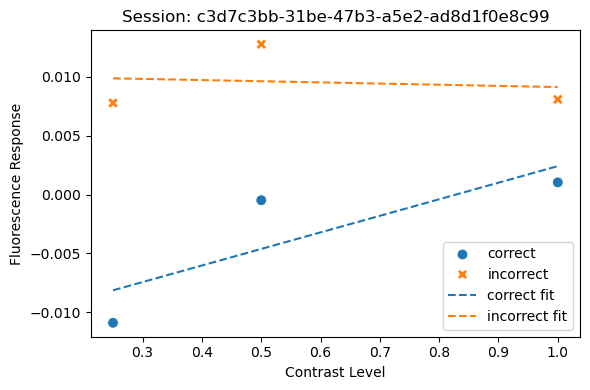

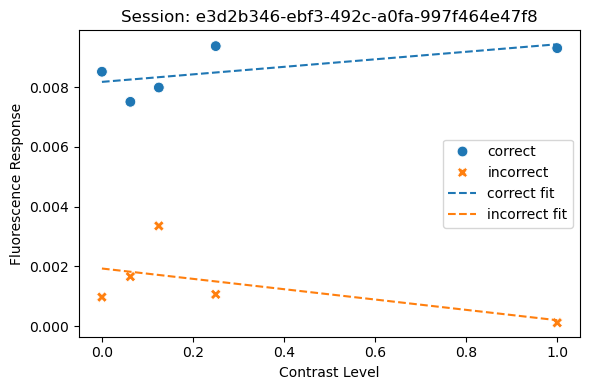

In [23]:
for eid in eid_qcd[25:30]:
    reg_results, session_df = run_rpe_regressions(eid)
    plot_session_fit(session_df, reg_results)

### Paired t-test

In [24]:
# Pivot to get slopes for both correct and incorrect in the same row
pivot_df = regression_results_df.pivot(index='session_id', columns='correctness', values='slope').dropna()

# Paired t-test comparing correct vs. incorrect slopes
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(pivot_df['correct'], pivot_df['incorrect'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3g}")

pivot_df

Paired t-test: t = 2.845, p = 0.00503


correctness,correct,incorrect
session_id,,
00dd4f06-6365-4f28-a961-b4085d7bbebc,0.013805,0.019082
075a551f-ae82-4b9a-b659-fe94b638b7aa,0.000949,0.001011
0a8ad5c0-7490-4c99-b693-19110a65e18d,-0.000760,-0.000126
0e5090dd-466b-45fa-aaba-34e40fe77d6e,0.000461,0.000612
0eea87bb-2b4d-433f-8ae8-6bd689357cee,0.000928,0.000245
...,...,...
fb11c0f9-f93f-4803-9a67-371dfb56bdd8,0.001342,0.002092
fd22820d-a2c2-4c06-b90e-f399344e1c0a,-0.002684,0.004900
fdae1a4d-639e-4d22-b065-777cebd3742f,0.000337,0.005238


### One sample t-test

In [175]:
from scipy.stats import ttest_1samp

correct_slopes = regression_results_df[regression_results_df['correctness'] == 'correct']['slope']
incorrect_slopes = regression_results_df[regression_results_df['correctness'] == 'incorrect']['slope']

# Drop NaNs?
correct_slopes = correct_slopes.dropna()
incorrect_slopes = incorrect_slopes.dropna()

# Test if correct slopes are significantly different from 0
t_corr, p_corr = ttest_1samp(correct_slopes, 0)
print(f"Correct trials: t = {t_corr:.3f}, p = {p_corr:.3g}")

# Test if incorrect slopes are significantly different from 0
t_incorr, p_incorr = ttest_1samp(incorrect_slopes, 0)
print(f"Incorrect trials: t = {t_incorr:.3f}, p = {p_incorr:.3g}")

mean_corr = correct_slopes.mean()

if mean_corr > 0:
    print(f"The slope for correct trials is significantly positive: {mean_corr:.4f}")
elif mean_corr < 0:
    print(f"The slope for correct trials is significantly negative: {mean_corr:.4f}")
else:
    print("The slope for correct trials is exactly zero.")


Correct trials: t = 4.607, p = 8.35e-06
Incorrect trials: t = -1.019, p = 0.31
The slope for correct trials is significantly positive: 0.0013


### visualize paired slope comparisons

/var/folders/yf/sbx6hw912yj3mshqmz5gwlmr0000gn/T/ipykernel_70812/2659946810.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=regression_results_df, x='correctness', y='slope', inner=None, palette='pastel')


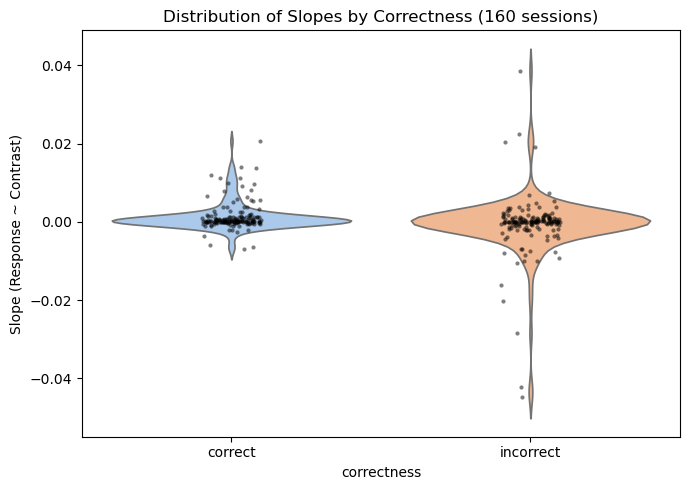

In [176]:
plt.figure(figsize=(7, 5))
sns.violinplot(data=regression_results_df, x='correctness', y='slope', inner=None, palette='pastel')
sns.stripplot(data=regression_results_df, x='correctness', y='slope',
              color='black', size=3, jitter=True, alpha=0.5)
plt.title("Distribution of Slopes by Correctness (160 sessions)")
plt.ylabel("Slope (Response ~ Contrast)")
plt.tight_layout()
plt.show()


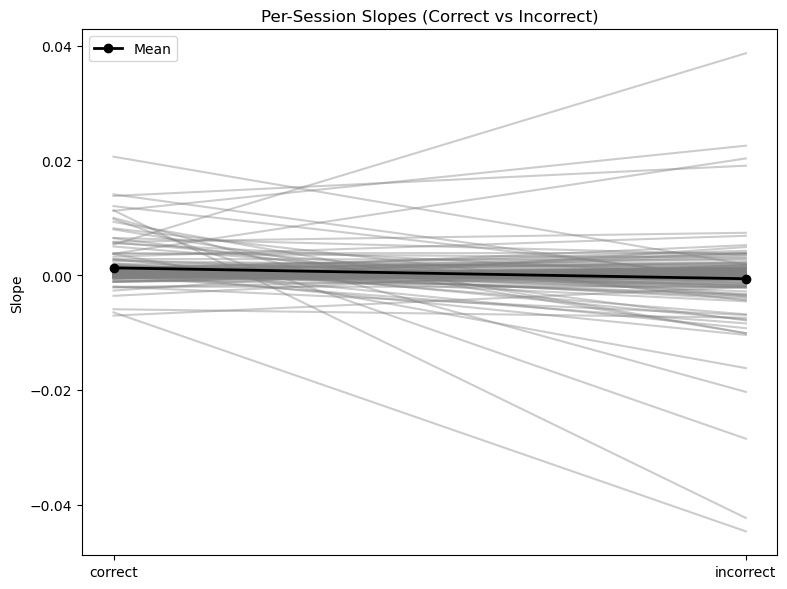

In [177]:
pivot_df = regression_results_df.pivot(index='session_id', columns='correctness', values='slope').dropna()

plt.figure(figsize=(8, 6))
for _, row in pivot_df.iterrows():
    plt.plot(['correct', 'incorrect'], [row['correct'], row['incorrect']], color='gray', alpha=0.4)

plt.plot(['correct', 'incorrect'], [pivot_df['correct'].mean(), pivot_df['incorrect'].mean()],
         marker='o', color='black', linewidth=2, label='Mean')
plt.ylabel("Slope")
plt.title("Per-Session Slopes (Correct vs Incorrect)")
plt.legend()
plt.tight_layout()
plt.show()


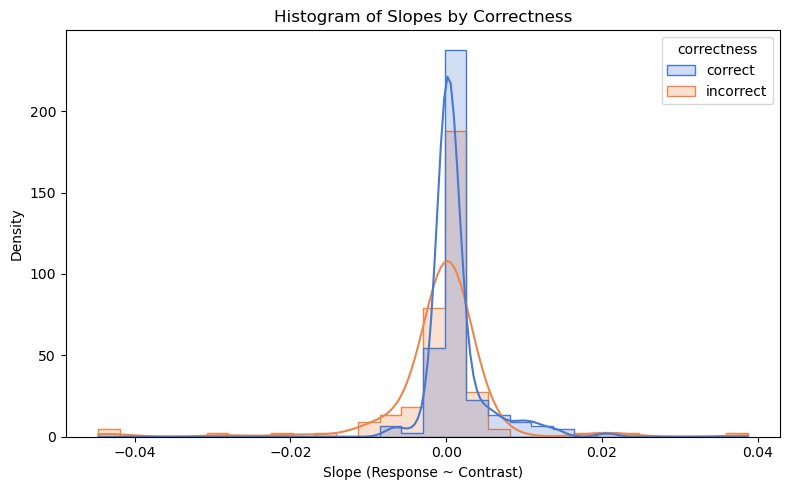

In [178]:
plt.figure(figsize=(8, 5))
sns.histplot(data=regression_results_df, x='slope', hue='correctness', bins=30,
             kde=True, palette='muted', element='step', stat='density', common_norm=False)
plt.title("Histogram of Slopes by Correctness")
plt.xlabel("Slope (Response ~ Contrast)")
plt.tight_layout()
plt.show()


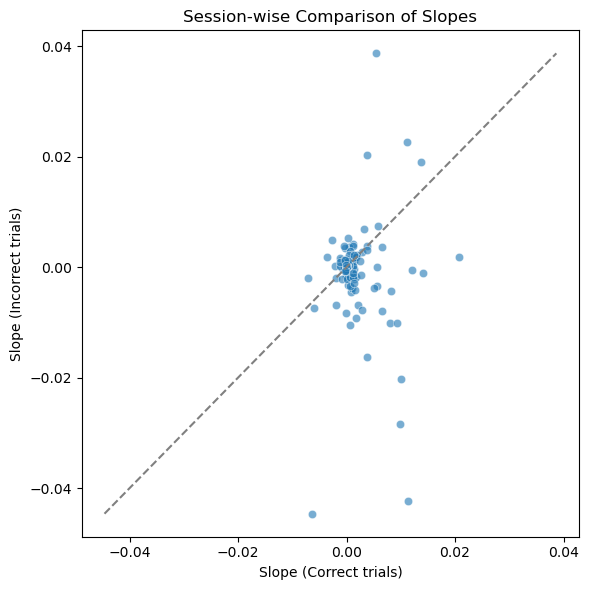

In [31]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='correct', y='incorrect', data=pivot_df, alpha=0.6)
plt.plot([pivot_df.min().min(), pivot_df.max().max()],
         [pivot_df.min().min(), pivot_df.max().max()],
         '--', color='gray')  # identity line
plt.xlabel("Slope (Correct trials)")
plt.ylabel("Slope (Incorrect trials)")
plt.title("Session-wise Comparison of Slopes")
plt.tight_layout()
plt.show()
